**Table of contents**<a id='toc0_'></a>    
- [Fitting the ZnPc XRR Data](#toc1_)    
  - [Fit 250 eV Data](#toc1_1_)    
    - [Load the 250 eV data](#toc1_1_1_)    
    - [Masking 250 eV](#toc1_1_2_)    
    - [Construct the slab structure for the data](#toc1_1_3_)    
    - [Construct the Objective Function](#toc1_1_4_)    
      - [Constraining the parameters](#toc1_1_4_1_)    
    - [Fitting the data](#toc1_1_5_)    
  - [Fit 283.7 eV Data](#toc1_2_)    
    - [Load the 283.7 eV data](#toc1_2_1_)    
      - [Various Masking Attempts](#toc1_2_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

In [2]:
import pyref as rf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *

Duplicate key in file 'C:\\\\Users\\\\Harlan Heilman\\\\pyref\\\\src\\\\pyref\\\\themes.mplstyle', line 44 ('grid.linewidth: .5')

Bad key axes.minor.ticks in file C:\\Users\\Harlan Heilman\\pyref\\src\\pyref\\themes.mplstyle, line 25 ('axes.minor.ticks : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key grid.which in file C:\\Users\\Harlan Heilman\\pyref\\src\\pyref\\themes.mplstyle, line 45 ('grid.which: both')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


# <a id='toc1_'></a>[Fitting the ZnPc XRR Data](#toc0_)
**Harlan Heilman**
---
## <a id='toc1_1_'></a>[Fit 250 eV Data](#toc0_)

The steps to fit the ZnPc XRR data are as follows:
1. Load the 250 eV data
    1. Convert the csv file to a pandas dataframe
    2. Plot the data and see if it looks reasonable - If not, mask the data
    3. Convert the data to a ReflectDataSet
2. Construct the slab structure for the data
    1. Vacuum | ZnPc | Amorphous Carbon | SiO2 | Si
3. Construct the Objective Function
    1. Create models for sp polarization
    2. Create objective functions for 250 eV
    3. Add thick - rough constraints to the prior for each layer
4. Fit the data

### <a id='toc1_1_1_'></a>[Load the 250 eV data](#toc0_)

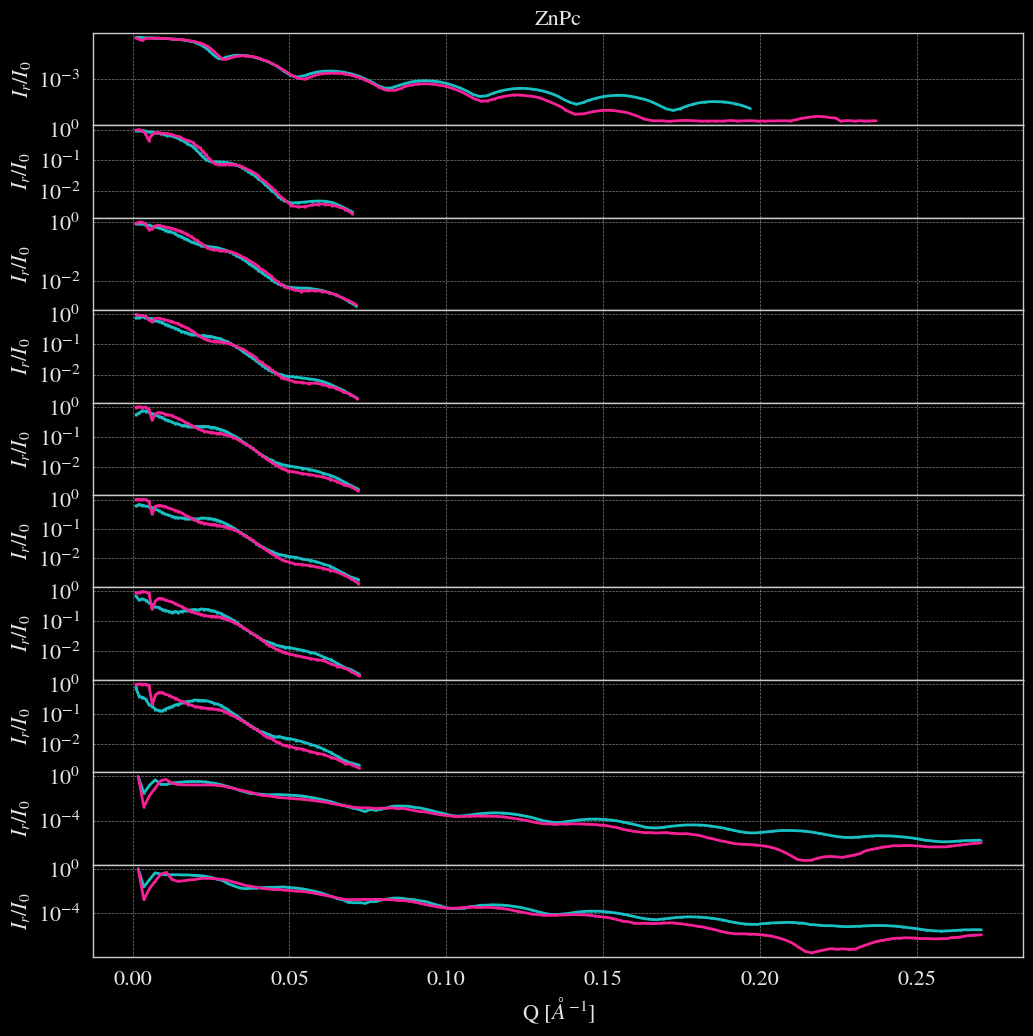

In [3]:
db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")
znpc_mono = {
    "250": {
        "s": db.get_refl("zrt_250.0_100.csv", "ZnPc"),
        "p": db.get_refl("zrt_250.0_190.csv", "ZnPc"),
        },
    "275": {
        "s": db.get_refl("275.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("275.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "280": {
        "s": db.get_refl("280.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("280.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "281": {
        "s": db.get_refl("281.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("281.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282": {
        "s": db.get_refl("282.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282.3": {
        "s": db.get_refl("282.3_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.3_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282.7": {
        "s": db.get_refl("282.7_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.7_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.1": {
        "s": db.get_refl("283.1_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("283.1_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.7": {
        "s": db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc"),
    },
    "284.1": {
        "s": db.get_refl("ZnPc_284.0_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_284.0_190.0 (CCD Scan 82869).parquet", "ZnPc"),
        },
}

fig, ax = plt.subplots(nrows = len(znpc_mono.keys()), figsize = (12, 12),sharex=True, gridspec_kw={"hspace":0})

for i, (k,v) in enumerate(znpc_mono.items()):
    v["s"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "s", logy = True, color = "C0", legend = False)
    v["p"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "p", logy = True, color = "C1", legend = False)

    if i == 0:
        ax[i].set(
            title = "ZnPc",
            ylabel = r"$I_r / I_0$",
        )
    elif i == len(znpc_mono.keys()) - 1:
        ax[i].set(
            xlabel = r"Q [$\AA^{-1}$]",
            ylabel = r"$I_r / I_0$",
        )
    else:
        ax[i].set(
            ylabel = r"$I_r / I_0$",
        )

In [4]:
def save_optical_constant(energy: float, slab: None | PXR_Slab = None, oc_df: pd.Series | None = None) -> pd.Series:
    if oc_df is None:
        oc_df = pd.Series(index=[
            "xx",
            "zz",
            "dxx",
            "dzz",
            "delta",
            "ddelta",
            "ixx",
            "izz",
            "dixx",
            "dizz",
            "beta",
            "dbeta",
            "energy"])
    if slab is None:
        return oc_df
    else:
        oc_df["xx"] = slab.sld.xx.value
        oc_df["zz"] = slab.sld.zz.value
        oc_df["dxx"] = slab.sld.xx.stderr
        oc_df["dzz"] = slab.sld.zz.stderr
        oc_df["delta"] = slab.sld.delta.value
        oc_df["ddelta"] = slab.sld.delta.stderr
        oc_df["ixx"] = slab.sld.ixx.value
        oc_df["izz"] = slab.sld.izz.value
        oc_df["dixx"] = slab.sld.ixx.stderr
        oc_df["dizz"] = slab.sld.izz.stderr
        oc_df["beta"] = slab.sld.beta.value
        oc_df["dbeta"] = slab.sld.beta.stderr
        oc_df["energy"] = energy
        return oc_df

### <a id='toc1_1_2_'></a>[Masking 250 eV](#toc0_)

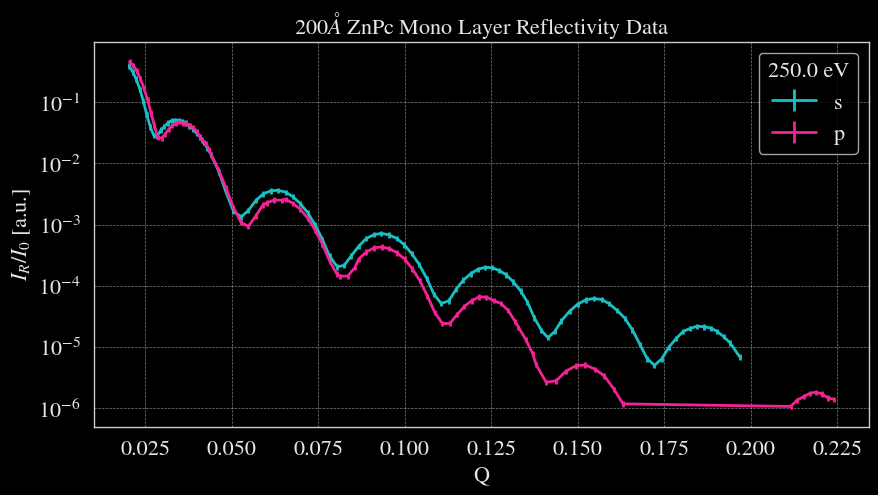

In [5]:
znpc_mono_250_s = rf.smart_mask(znpc_mono["250"]["s"])
znpc_mono_250_p = rf.smart_mask(znpc_mono["250"]["p"], pol = "p")

fig, ax = plt.subplots()
znpc_mono_250_s.plot(ax = ax, x = "Q", y = "Refl", yerr="Err")
znpc_mono_250_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax.legend(title = "250.0 eV", labels = ["s", "p"])

znpc_mono_250 = rf.to_refnx_dataset(znpc_mono_250_s, pol = "sp", second_pol=znpc_mono_250_p)

### <a id='toc1_1_3_'></a>[Construct the slab structure for the data](#toc0_)

I have allready fit this structure several times. So I will just load the structure from a .json file. 

In [6]:
# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

si_thick = znpc_mono_struct_file["Si"]["thickness"]
si_rough = znpc_mono_struct_file["Si"]["roughness"]
si_density = znpc_mono_struct_file["Si"]["density"]

sio2_thick = znpc_mono_struct_file["SiO2"]["thickness"]
sio2_rough = znpc_mono_struct_file["SiO2"]["roughness"]
sio2_density = znpc_mono_struct_file["SiO2"]["density"]

c_amor_thick = znpc_mono_struct_file["C"]["thickness"]
c_amor_rough = znpc_mono_struct_file["C"]["roughness"]
c_amor_density = znpc_mono_struct_file["C"]["density"]

znpc_thick = znpc_mono_struct_file["C32H16N8Zn"]["thickness"]
znpc_rough = znpc_mono_struct_file["C32H16N8Zn"]["roughness"]
znpc_density = znpc_mono_struct_file["C32H16N8Zn"]["density"]

## <a id='toc1_2_'></a>[Fit 275](#toc0_)

-0.009678525253008245


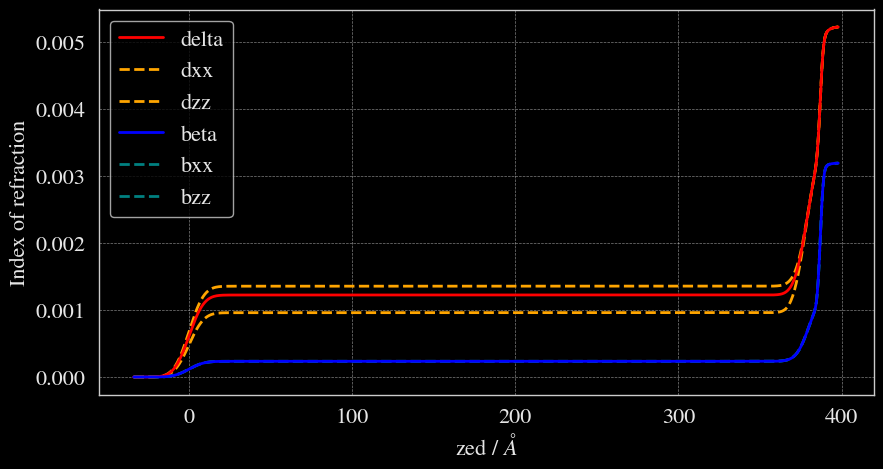

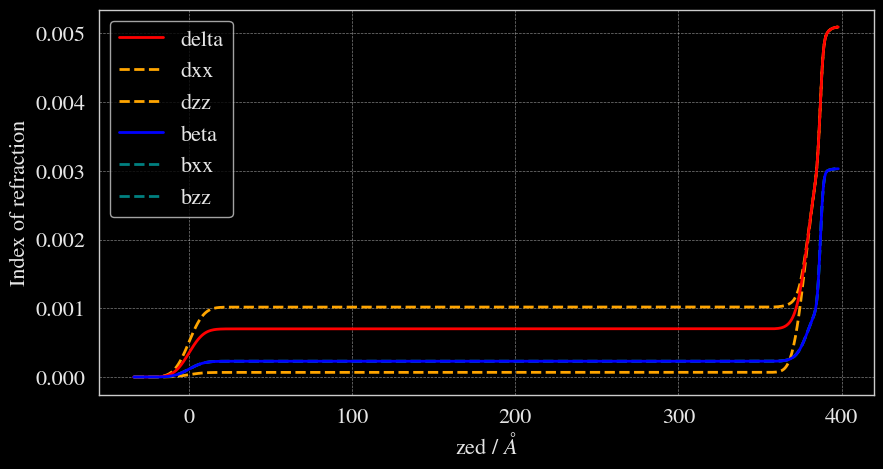

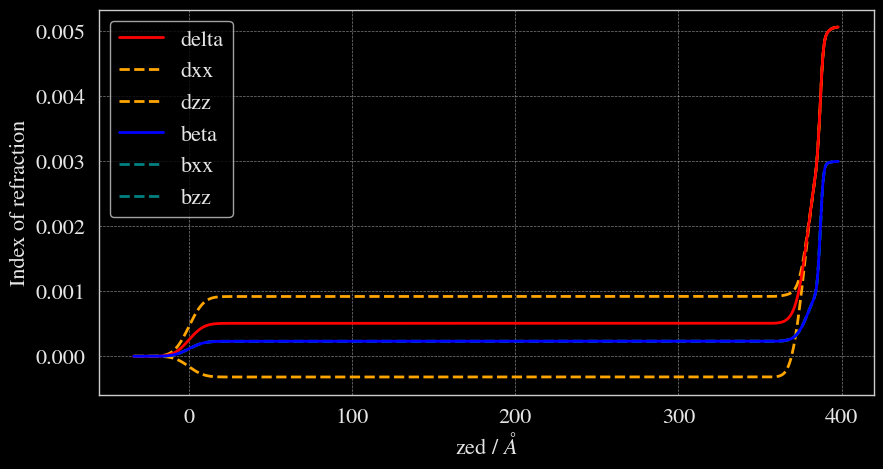

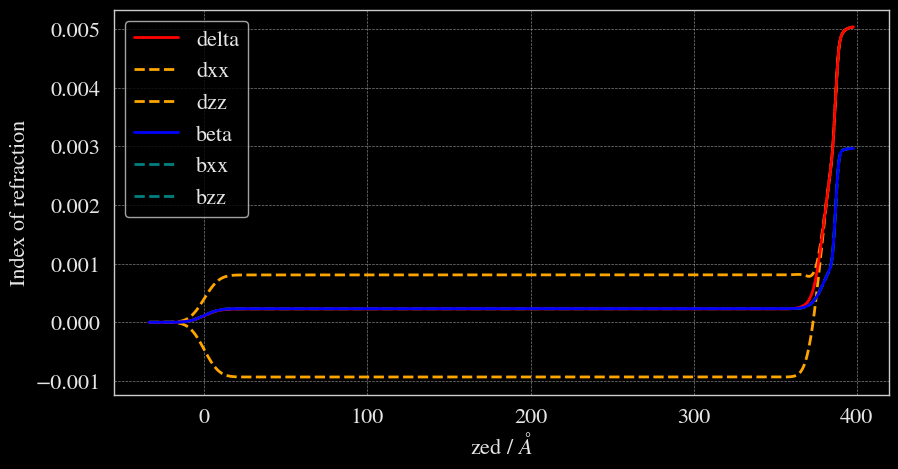

In [7]:
ens = [275, 280, 281, 282]

ns = [np.array([znpc_oc["xx"].n(en), znpc_oc["zz"].n(en)]) for en in ens]
biref = [znpc_oc["xx"].delta(en) + znpc_oc["zz"].delta(en) for en in ens]
dichro = [znpc_oc["xx"].beta(en) - znpc_oc["zz"].beta(en) for en in ens]

ratio = np.average([d / b for d, b in zip(dichro, biref)])
print(ratio)


vac = [PXR_MaterialSLD("", 0, en)(0, 0) for en in ens]
si = [PXR_MaterialSLD("Si", 2.33, en, name="Si")(si_thick,si_rough) for en in ens]
sio2 = [PXR_MaterialSLD("SiO2", sio2_density, en, name="SiO2")(sio2_thick,sio2_rough) for en in ens]
c_amor = [PXR_MaterialSLD("C", c_amor_density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough) for en in ens]

znpc_surf_thick = 10

znpc = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc")(znpc_thick-znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

znpc_surf = [PXR_SLD(ns[i], symmetry="uni", name = "ZnPc_surf")(znpc_thick-znpc_surf_thick, znpc_rough) for i, _ in enumerate(ens)]

structs = [vac[i] | znpc_surf[i] | znpc[i] | c_amor[i] | sio2[i] | si[i] for i in range(len(ens))]

for struc in structs:
    struc.plot()


In [8]:
zz_bounds =[
    (0,.005),
    (0,.005),
    (-.005,0),
    (-.005,0),
]

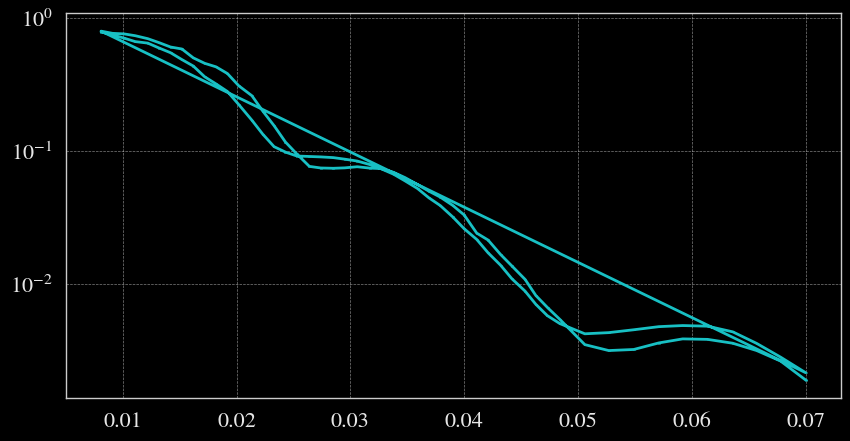

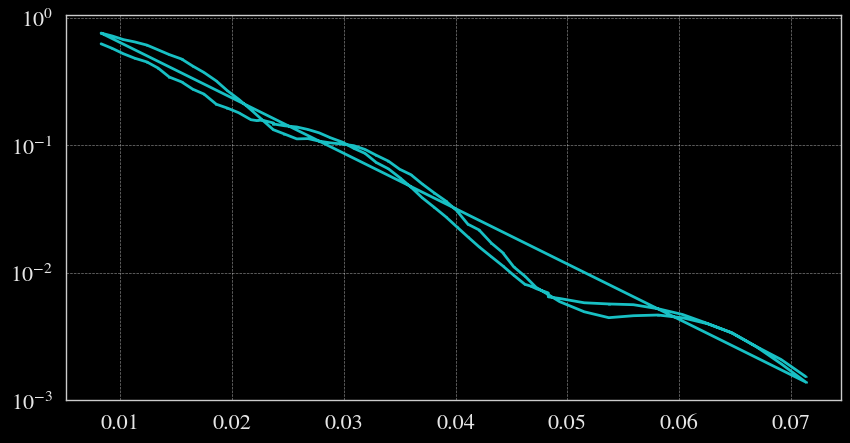

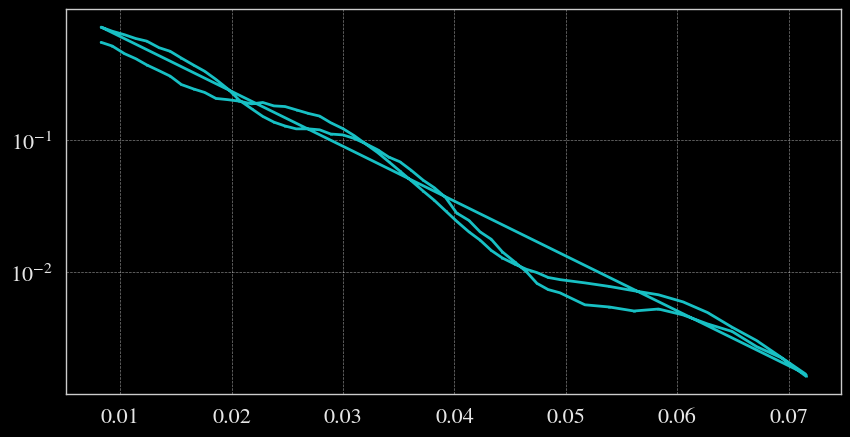

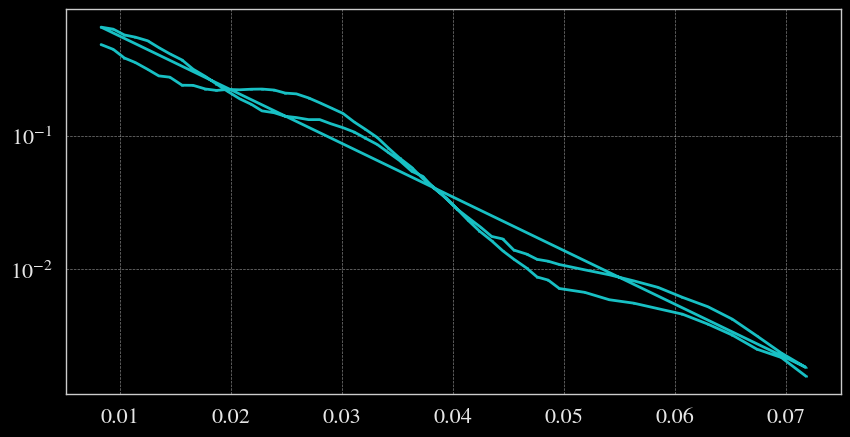

In [9]:
znpc_mono_series = []

for i, en in enumerate(ens):
    cutoff = 7 if i <= 3 else 8
    s = znpc_mono[f"{en}"]["s"].iloc[cutoff:]
    p = znpc_mono[f"{en}"]["p"].iloc[cutoff:]
    refl_data = rf.to_refnx_dataset(s, pol = "sp", second_pol=p)
    refl_data.plot()
    plt.yscale("log")
    znpc_mono_series.append(refl_data)

In [10]:
for slab in si:
    slab.thick.setp(vary = False)
    slab.rough.setp(vary = False)

for slab in sio2:
    slab.thick.setp(vary = None, constraint = sio2_thick)
    slab.rough.setp(vary = None, constraint = sio2_rough)
    slab.sld.density.setp(vary = None, constraint = sio2_density)

for slab in c_amor:
    slab.thick.setp(vary = None, constraint = c_amor_thick)
    slab.rough.setp(vary = None, constraint = c_amor_rough)
    slab.sld.density.setp(vary = None, constraint = c_amor_density)

for i, slab in enumerate(znpc):
    slab.thick.setp(vary = True, bounds = (slab.thick.value * .5, slab.thick.value * 1.5))
    slab.rough.setp(vary = True, bounds = (0, 10))

    slab.sld.xx.setp(vary = True, bounds = (0, 0.005))
    slab.sld.zz.setp(vary = True, bounds = zz_bounds[i])

    slab.sld.ixx.setp(vary=True, bounds = (slab.sld.beta.value*.5, slab.sld.beta.value*1.5))
    slab.sld.izz.setp(vary=None, constraint=slab.sld.ixx)

for slab in znpc_surf:
    slab.thick.setp(vary = None, constraint=znpc_thick-znpc[i].thick.value)
    slab.rough.setp(vary = True, bounds = (0, 10))

    slab.sld.xx.setp(vary = True, bounds = (-.005, .005))
    slab.sld.zz.setp(vary = True, bounds = (-.005, .005))

    slab.sld.ixx.setp(vary=True, bounds = (slab.sld.beta.value*.5, slab.sld.beta.value*1.5))
    slab.sld.izz.setp(vary=None, constraint=slab.sld.ixx)


In [11]:
from pyref.fitting.logp import LogpExtra_rough


objs = []
for i, en in enumerate(ens):
    model = PXR_ReflectModel(structs[i], pol = "sp", energy = en, q_offset=.001, name = f"ZnPc Mono Layer {en}eV")
    model.scale.setp(vary = True, bounds = (0.6, 1.2))
    model.bkg.setp(vary = True, bounds = (1e-9, 1e-6))
    model.q_offset.setp(vary = True, bounds = (-.01, 0.01))

    obj = Objective(model, znpc_mono_series[i], transform=Transform("logY"))
    lpe = LogpExtra_rough(obj)
    obj.logp_extra = lpe
    objs.append(obj)

180


  0%|          | 0/540 [00:00<?, ?it/s]c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\refnx\_lib\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 540/540 [00:50<00:00, 10.72it/s]


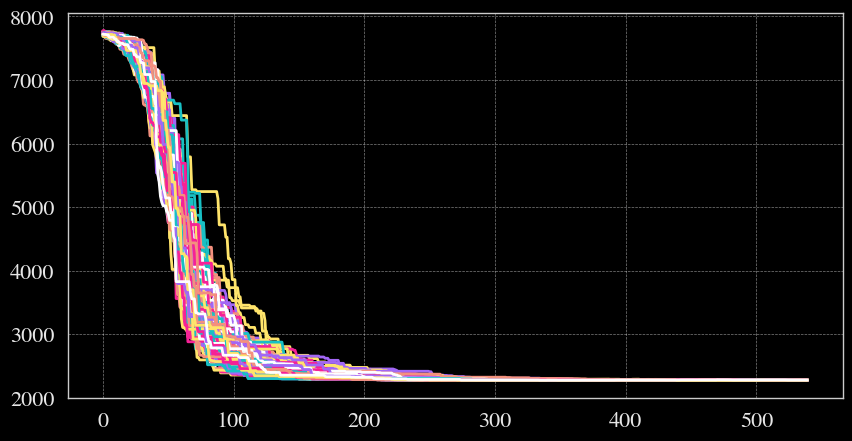

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.11174 +/- 0.0221, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=6.06296e-07 +/- 2.8e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'q_offset'   , value=0.000367117 +/- 5.27e-05, bounds=[-0.01, 0.01]>
<Parameter:'ZnPc_surf_xx' , value=-0.000123401 +/- 0.00014, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_ixx', value=0.000318108 +/- 5.71e-05, bounds=[0.00011722334046425946, 0.0003516700213927784]>
<Parameter:'ZnPc_surf_zz' , value=-0.00120455 +/- 0.000392, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_rough', value=2.08332  +/- 1.9 , bounds=[0.0, 10.0]>
<Parameter: 'ZnPc_thick'  , value=201.45 +/- 2.11 , bounds=[93.2205, 279.6615]>
<Parameter:   'ZnPc_xx'   , value=0.00135144 +/- 2.76e-05, bounds=[0.0, 0.005]>
<Parameter:  'ZnPc_ixx'   , value=0.000320522 +/- 9.17e-06, bounds=[0.00011722334046425946, 0.0003516700213927784]>
<Parameter:   'ZnPc

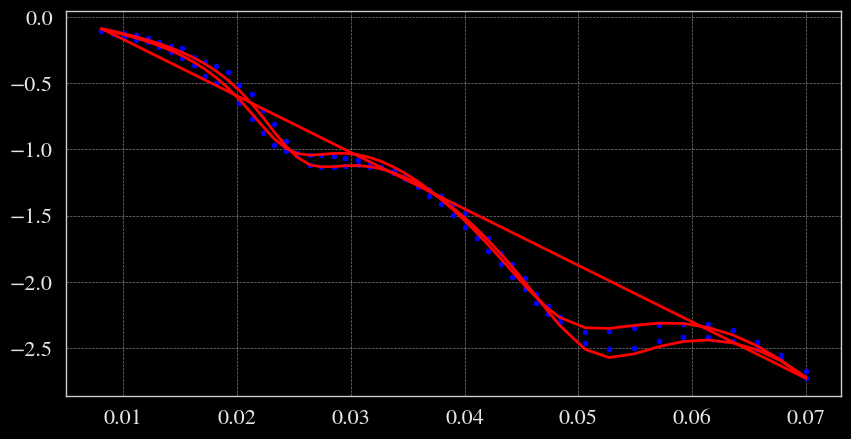

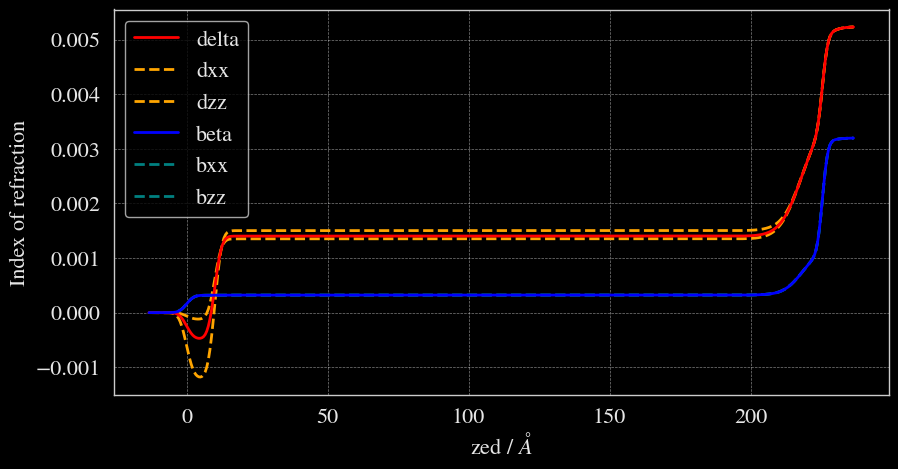

100%|██████████| 540/540 [00:50<00:00, 10.67it/s]


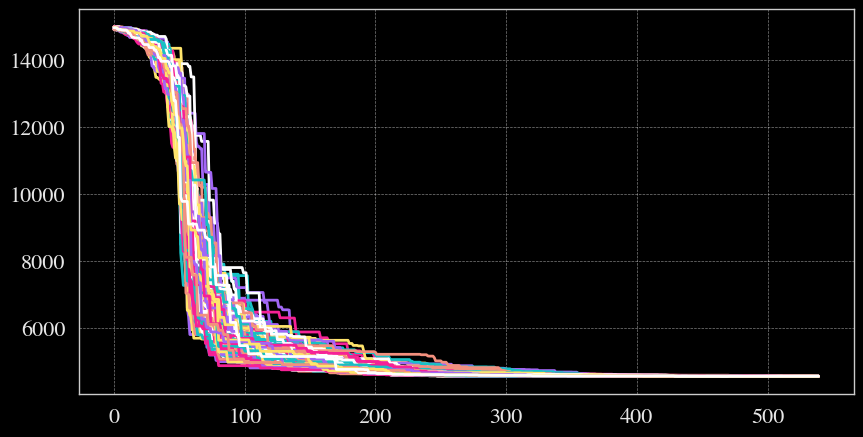

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.05842 +/- 0.0424, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.85057e-07 +/- 3.05e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'q_offset'   , value=0.000455559 +/- 0.000303, bounds=[-0.01, 0.01]>
<Parameter:'ZnPc_surf_xx' , value=-3.86117e-05 +/- 0.000103, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_ixx', value=0.000131246 +/- 5.44e-05, bounds=[0.00011455427188945622, 0.0003436628156683687]>
<Parameter:'ZnPc_surf_zz' , value=-0.00118422 +/- 0.000345, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_rough', value=3.41189 +/- 1.96 , bounds=[0.0, 10.0]>
<Parameter: 'ZnPc_thick'  , value=203.337 +/- 2.02 , bounds=[93.2205, 279.6615]>
<Parameter:   'ZnPc_xx'   , value=0.000829271 +/- 1.41e-05, bounds=[0.0, 0.005]>
<Parameter:  'ZnPc_ixx'   , value=0.000268779 +/- 9.08e-06, bounds=[0.00011455427188945622, 0.0003436628156683687]>
<Parameter:   '

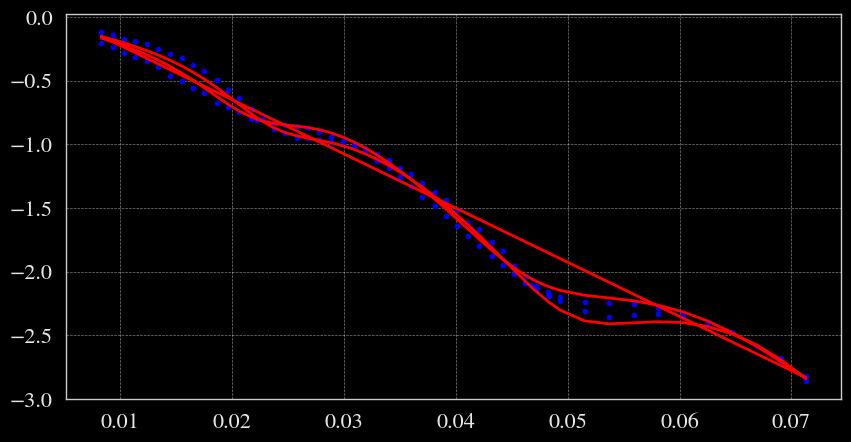

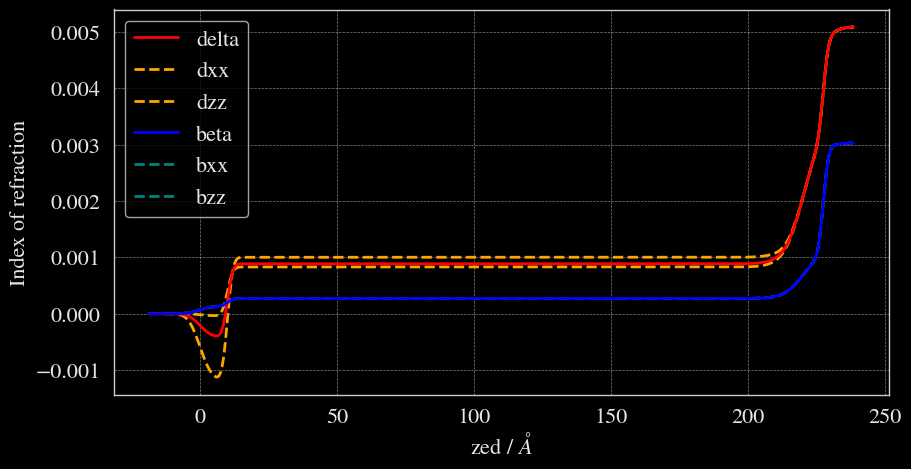

100%|██████████| 540/540 [00:46<00:00, 11.56it/s]


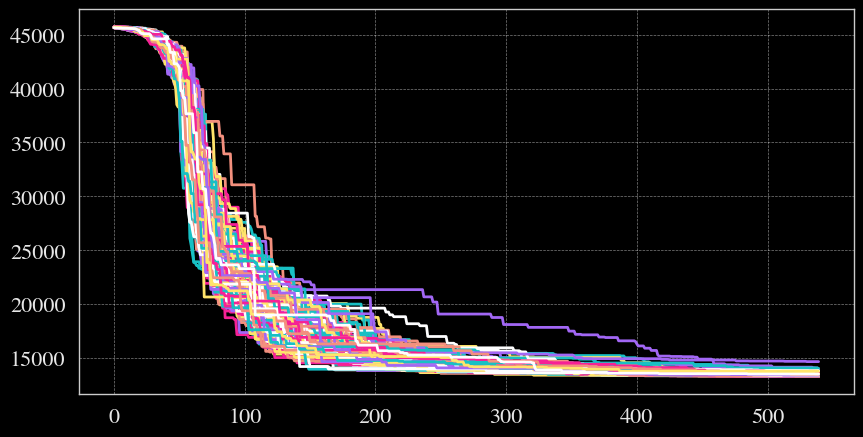

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.11018 +/- 0.105, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.87945e-07 +/- 3.02e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'q_offset'   , value=0.0037904 +/- 0.00142, bounds=[-0.01, 0.01]>
<Parameter:'ZnPc_surf_xx' , value=-0.00205876 +/- 0.000704, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_ixx', value=0.000166126 +/- 6.06e-05, bounds=[0.00011521121896881914, 0.00034563365690645743]>
<Parameter:'ZnPc_surf_zz' , value=-0.00277889 +/- 0.000666, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_rough', value=5.88964 +/- 2.62 , bounds=[0.0, 10.0]>
<Parameter: 'ZnPc_thick'  , value=214.684 +/- 4.07 , bounds=[93.2205, 279.6615]>
<Parameter:   'ZnPc_xx'   , value=9.64054e-05 +/- 0.000264, bounds=[0.0, 0.005]>
<Parameter:  'ZnPc_ixx'   , value=0.000153584 +/- 2.8e-05, bounds=[0.00011521121896881914, 0.00034563365690645743]>
<Parameter:   'ZnPc

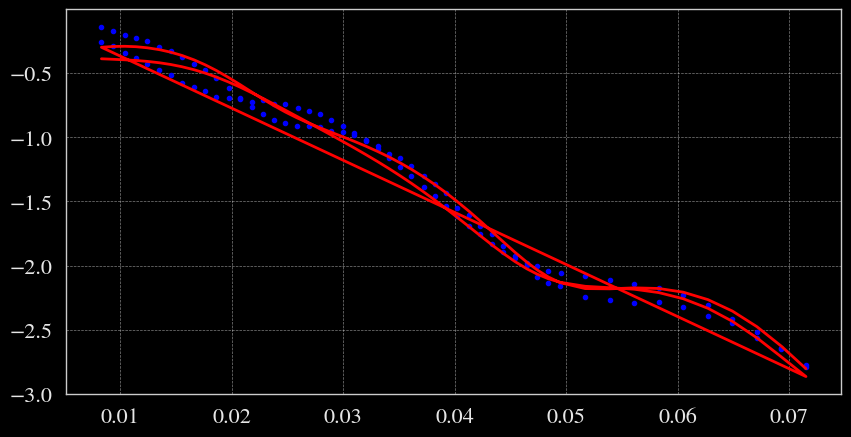

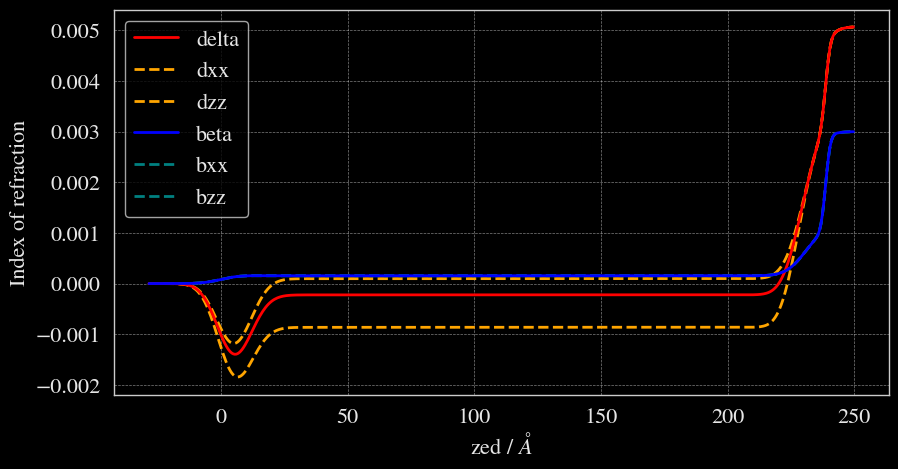

100%|██████████| 540/540 [00:47<00:00, 11.40it/s]


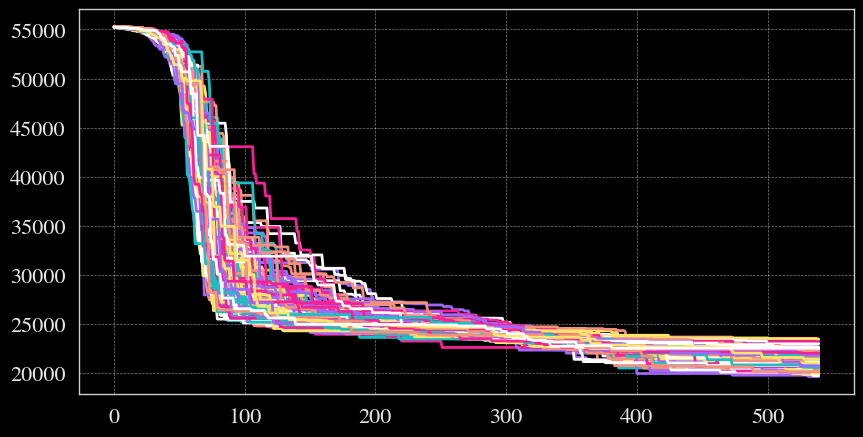

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.913285 +/- 0.139, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.10123e-07 +/- 3.03e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'q_offset'   , value=0.000151945 +/- 0.00103, bounds=[-0.01, 0.01]>
<Parameter:'ZnPc_surf_xx' , value=-0.000995382 +/- 0.000385, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_ixx', value=0.000166151 +/- 5.3e-05, bounds=[0.0001163491275493844, 0.0003490473826481532]>
<Parameter:'ZnPc_surf_zz' , value=-0.00255438 +/- 0.000871, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_rough', value=6.06547 +/- 1.87 , bounds=[0.0, 10.0]>
<Parameter: 'ZnPc_thick'  , value=227.826 +/- 13.6 , bounds=[93.2205, 279.6615]>
<Parameter:   'ZnPc_xx'   , value=0.000110496 +/- 0.000151, bounds=[0.0, 0.005]>
<Parameter:  'ZnPc_ixx'   , value=0.000154668 +/- 3.82e-05, bounds=[0.0001163491275493844, 0.0003490473826481532]>
<Parameter:   'ZnPc

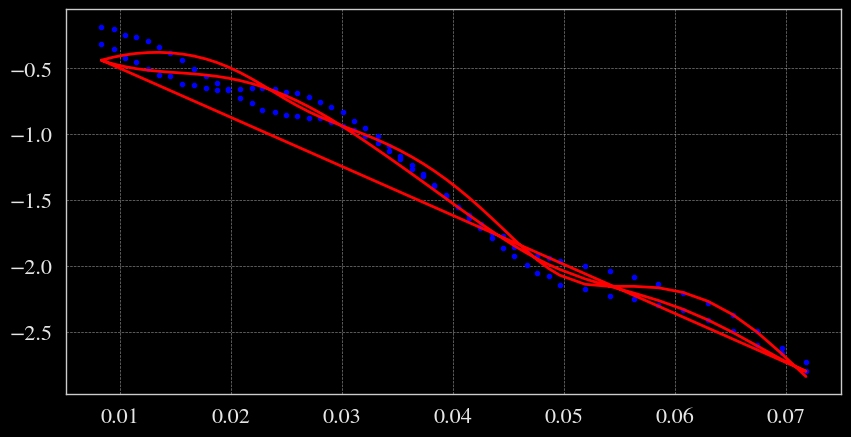

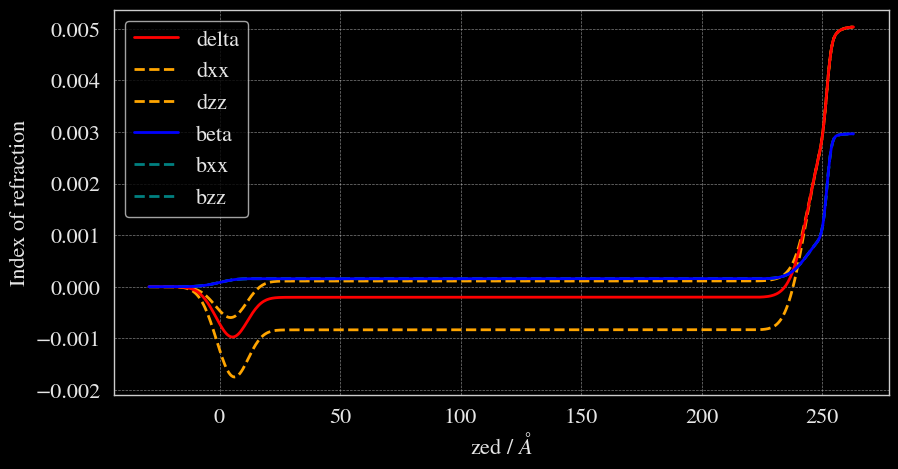

In [12]:
nwalkers = int(1.5*len(objs[0].varying_parameters())) * 10
print(nwalkers)
steps = 3*nwalkers
move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7, gamma0=1), 0.05)]
random_state = 120

for i, en in enumerate(ens):
    fitter = CurveFitter(objs[i], nwalkers=nwalkers, moves = move)
    fitter.initialise("prior")
    chain = fitter.sample(steps, random_state=random_state)
    fitter.initialise("jitter")
    chain = fitter.sample(steps, random_state=random_state)
    lp = fitter.logpost
    plt.plot(-lp)
    plt.show()

    print(objs[i].varying_parameters())
    objs[i].plot()
    plt.show()
    structs[i].plot()
    plt.show()

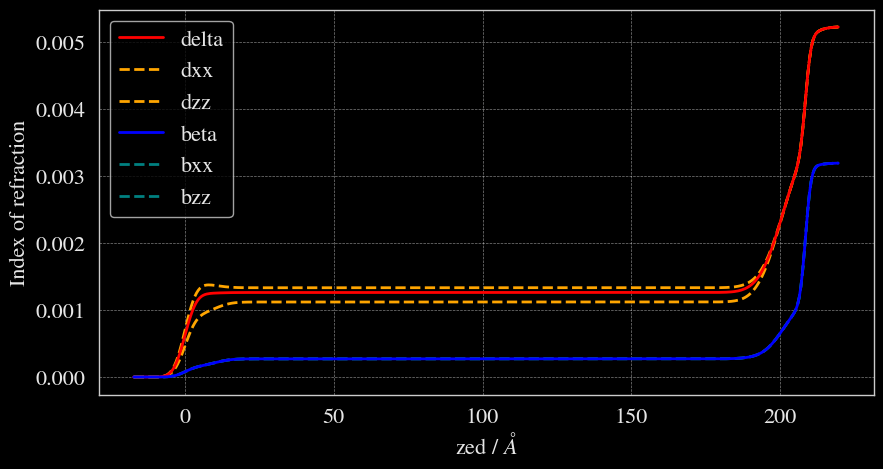

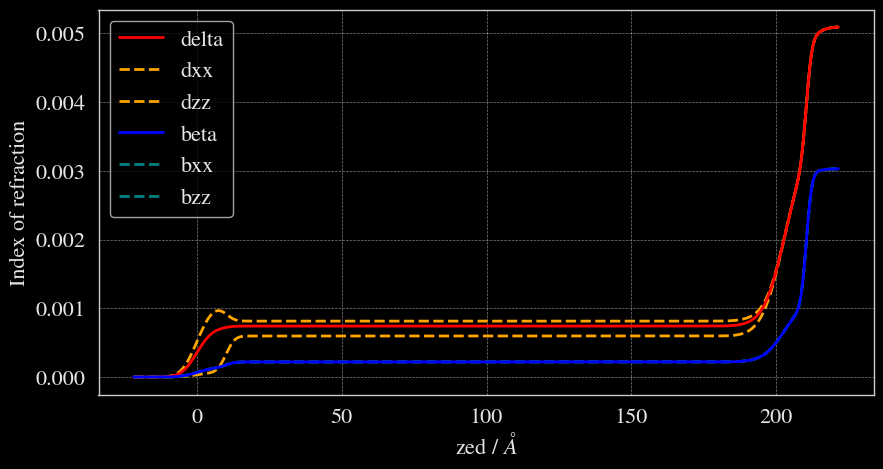

In [26]:
for struc in structs:
    struc.plot()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

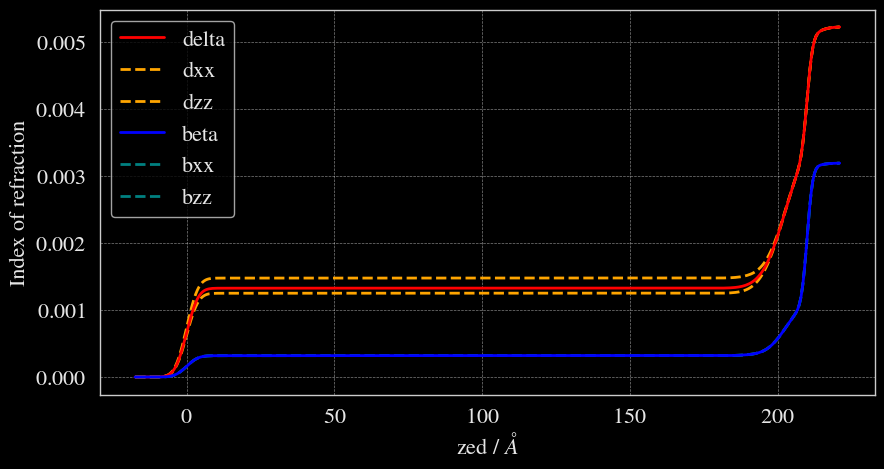

In [42]:
structs[0].plot()

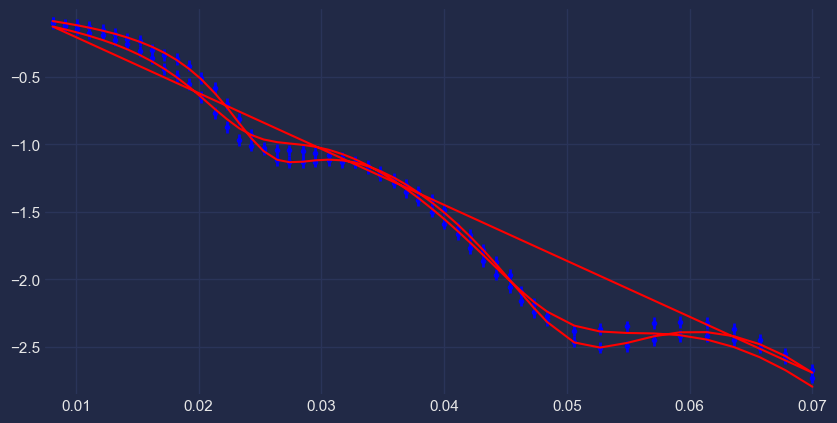

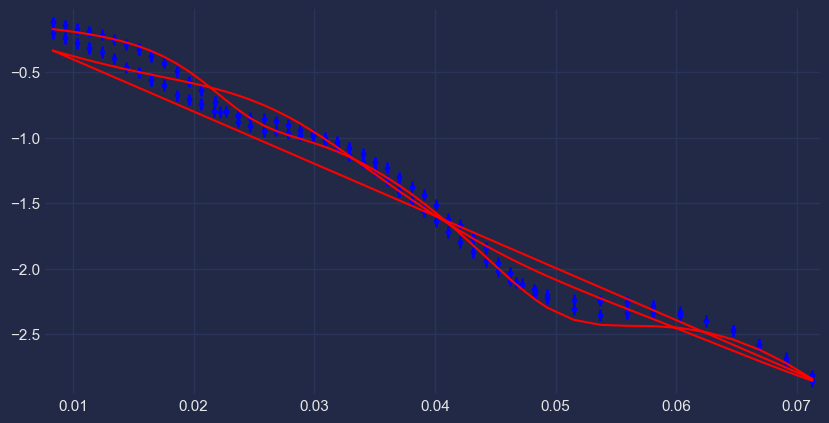

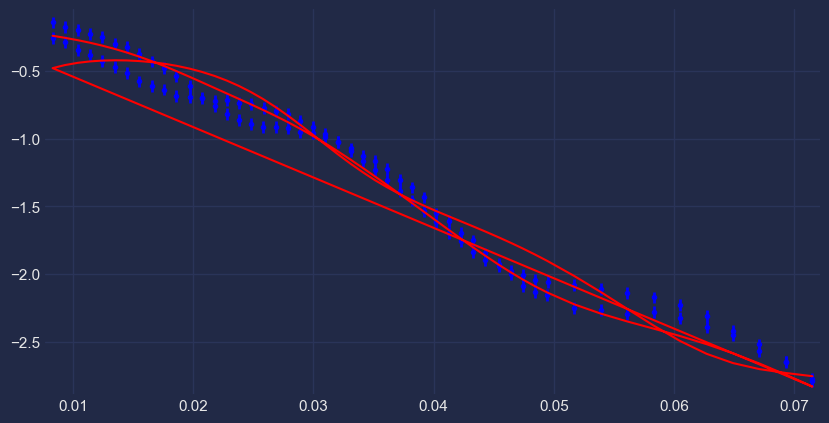

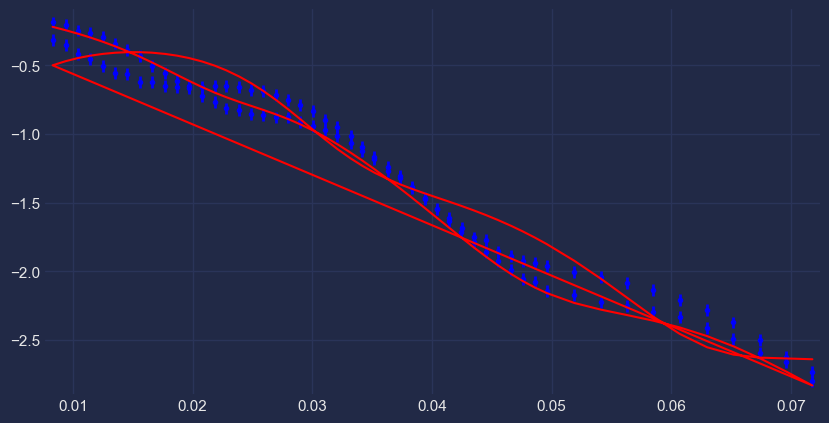

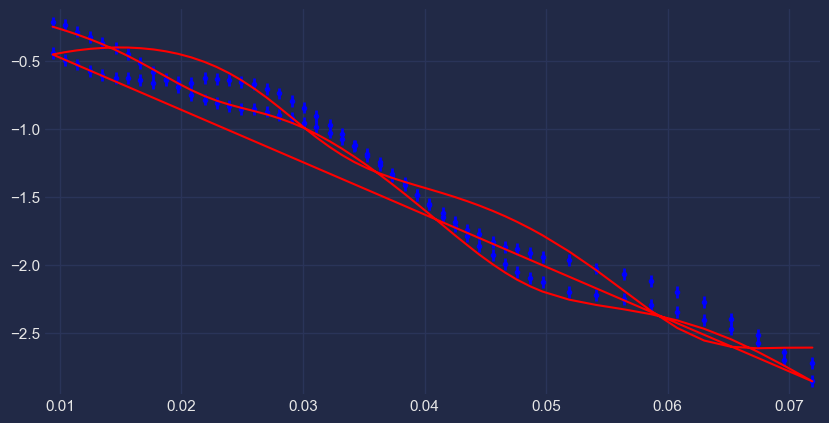

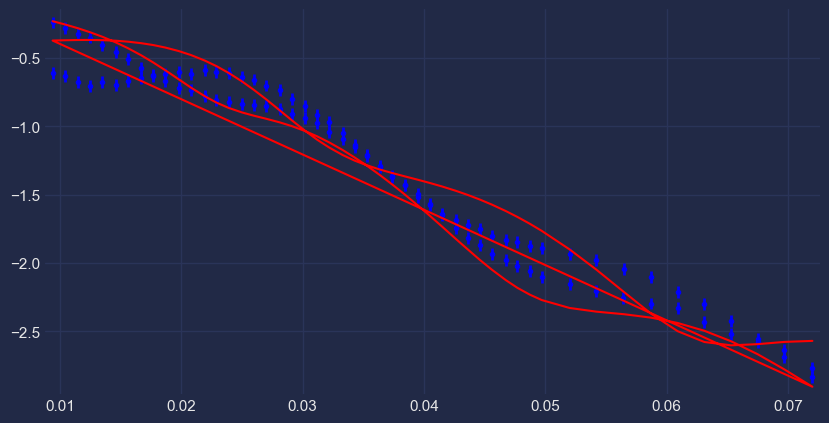

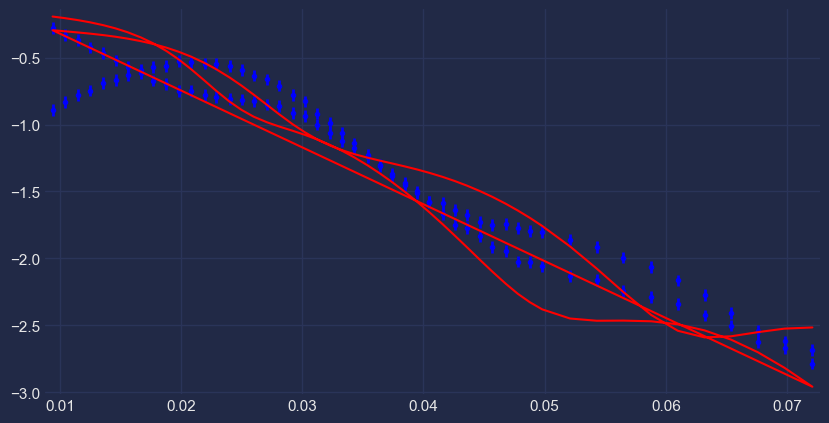

In [23]:
for i, _ in enumerate(ens):
    objs[i].plot()

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

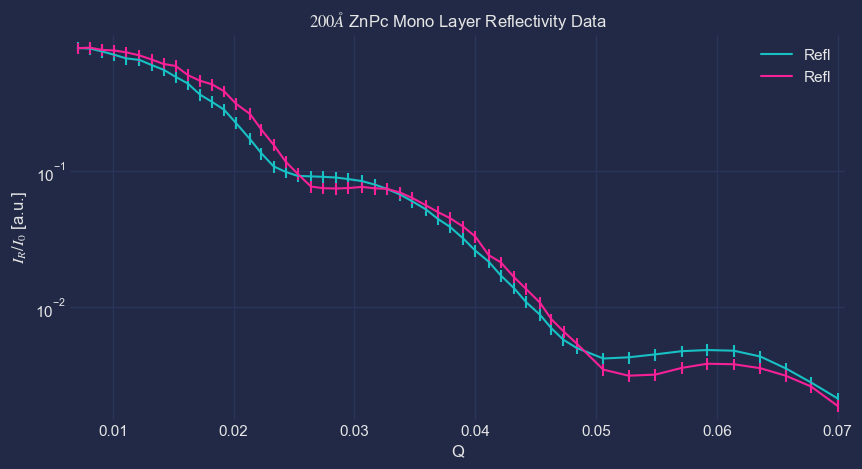

In [24]:
fig, ax = plt.subplots()

znpc_mono_275_s = znpc_mono["275"]["s"].iloc[6:]
znpc_mono_275_p = znpc_mono["275"]["p"].iloc[6:]

znpc_mono_275_s.plot(ax = ax, x = "Q", y = "Refl", yerr="Err")
znpc_mono_275_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")

znpc_mono_275 = rf.to_refnx_dataset(znpc_mono_275_s, pol = "sp", second_pol=znpc_mono_275_p)

ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

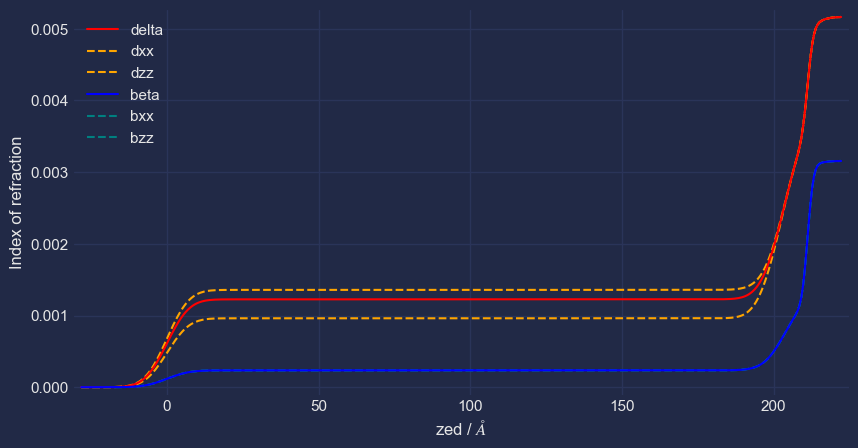

In [25]:
en = 275
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["xx"].n(en), znpc_oc["zz"].n(en)])

znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_275 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_275.plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

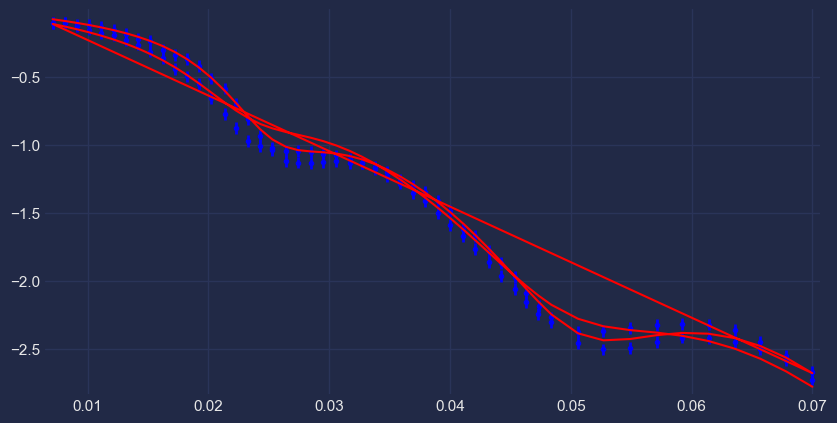

In [284]:
model_275 = PXR_ReflectModel(struct_275, pol = "sp", energy = en, name = "ZnPc Mono Layer 275eV")
model_275.scale.setp(vary = True, bounds = (0.6, 1.2))
model_275.bkg.setp(vary = True, bounds = (1e-9, 1e-6))


obj_275 = Objective(model_275, znpc_mono_275, transform=Transform("logY"))
obj_275.logp_extra = logp

obj_275.plot()

In [285]:
si_1.thick.setp(vary = False)
si_1.rough.setp(vary = False)

sio2_1.thick.setp(vary = None, constraint=sio2_thick)
sio2_1.rough.setp(vary = None, constraint=sio2_rough)
sio2_1.sld.density.setp(vary = None, constraint=sio2_density)

c_amor_1.thick.setp(vary = None, constraint=c_amor_thick)
c_amor_1.rough.setp(vary = None, constraint=c_amor_rough)
c_amor_1.sld.density.setp(vary = None, constraint=c_amor_density)

znpc_1.thick.setp(vary = None, constraint=znpc_thick)
znpc_1.rough.setp(vary = None, constraint=znpc_rough)

znpc_1.sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_1.sld.delta.setp(vary = True, bounds = (0,.002))

znpc_1.sld.xx.setp(vary = True, bounds = (znpc_1.sld.delta, .002))
znpc_1.sld.zz.setp(vary = True, bounds = (0, znpc_1.sld.delta))
znpc_1.sld.ixx.setp(vary = None, constraint = znpc_1.sld.beta)
znpc_1.sld.izz.setp(vary = None, constraint = znpc_1.sld.beta)

100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.01279 +/- 0.0343, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.04535e-07 +/- 3.38e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.00119909 +/- 0.000584, bounds=[0.0, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000293302 +/- 4.15e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.00126716 +/- 5.92e-05, bounds=[0.001225398173210506, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.00121116 +/- 0.000109, bounds=[0.0, 0.001225398173210506]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

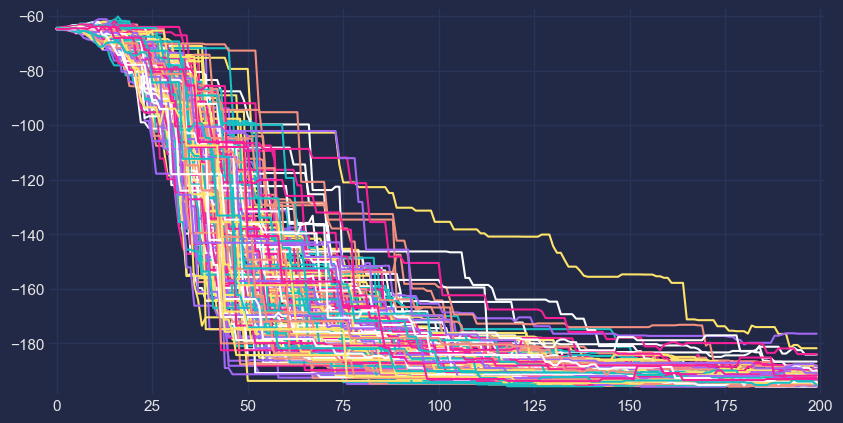

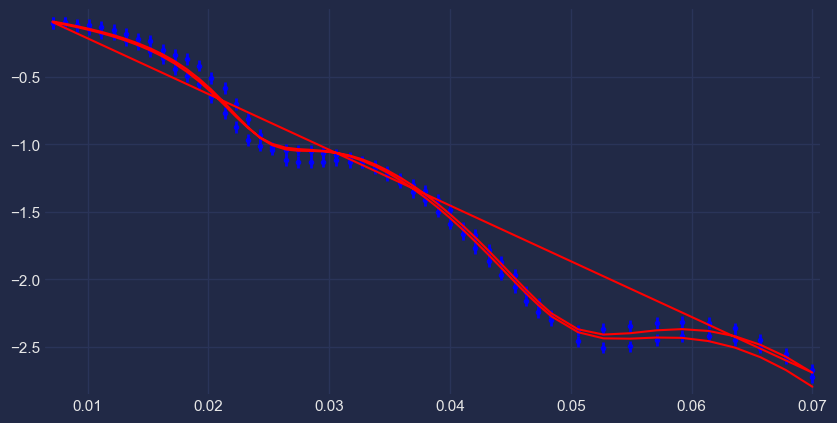

In [286]:
fitter = CurveFitter(obj_275, nwalkers=nwalkers, moves = move)
fitter.initialise("jitter")
chain = fitter.sample(int(nwalkers), random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(obj_275.varying_parameters())
obj_275.plot()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

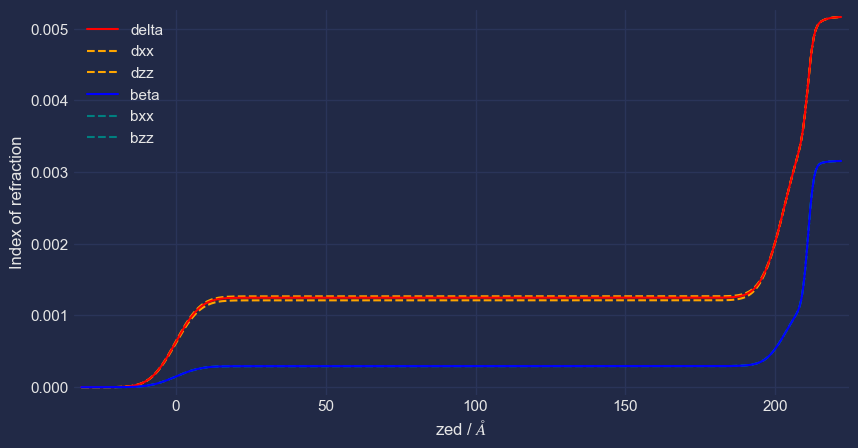

In [287]:
struct_275.plot()

In [288]:
# to_json(struct_275, db.res / "ZnPc_275eV_struct.json")
# to_json(obj_275, db.res / "ZnPc_275eV_obj.json")

# model_275_s = PXR_ReflectModel(struct_275, pol = "s", energy = 275, name = "ZnPc Mono Layer 275eV")(q)
# model_275_p = PXR_ReflectModel(struct_275, pol = "p", energy = 275, name = "ZnPc Mono Layer 275eV")(q)

# np.savetxt(db.res / "ZnPc_275eV_s_fit.txt", np.row_stack([q, model_275_s]), delimiter = ",")
# np.savetxt(db.res / "ZnPc_275eV_p_fit.txt", np.row_stack([q, model_275_p]), delimiter = ",")


oc_res.loc[oc_res["energy"] == "275", "xx"] = znpc_1.sld.xx.value
oc_res.loc[oc_res["energy"] == "275", "zz"] = znpc_1.sld.zz.value
oc_res.loc[oc_res["energy"] == "275", "dxx"] = znpc_1.sld.xx.stderr
oc_res.loc[oc_res["energy"] == "275", "dzz"] = znpc_1.sld.zz.stderr
oc_res.loc[oc_res["energy"] == "275", "delta"] = znpc_1.sld.delta.value
oc_res.loc[oc_res["energy"] == "275", "ddelta"] = znpc_1.sld.delta.stderr
oc_res.loc[oc_res["energy"] == "275", "ixx"] = znpc_1.sld.ixx.value
oc_res.loc[oc_res["energy"] == "275", "izz"] = znpc_1.sld.izz.value
oc_res.loc[oc_res["energy"] == "275", "dixx"] = znpc_1.sld.ixx.stderr
oc_res.loc[oc_res["energy"] == "275", "dizz"] = znpc_1.sld.izz.stderr
oc_res.loc[oc_res["energy"] == "275", "beta"] = znpc_1.sld.beta.value
oc_res.loc[oc_res["energy"] == "275", "dbeta"] = znpc_1.sld.beta.stderr


oc_res

C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_21672\3862221966.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0012671579928020648' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oc_res.loc[oc_res["energy"] == "275", "xx"] = znpc_1.sld.xx.value
C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_21672\3862221966.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0012111617575859854' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oc_res.loc[oc_res["energy"] == "275", "zz"] = znpc_1.sld.zz.value
C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_21672\3862221966.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.916137065707021e-05' has dtype incompatible with int64, p

xx        zz       dxx       dzz     delta    ddelta       ixx  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.001267  0.001211  0.000059  0.000109  0.001199  0.000584  0.000293   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        izz      dixx      dizz      beta     dbeta energy  
0  0.000000  0.000000  0.000000  0.000000  0.000000    250  
1  0.000293  0.000042  0.000042  0.000293  0.000042    275  
2  0.000000  0.000000  0.000000  0.000000  0.000000    280  
3  0.000000  0.000000  0.000000  0.000000  0.000000    281  
4  0.000000  0.000000  0.000000  0.000000  0.000000    282  
5  0.000000  0.000000  0.000000  0.000000  0.000000  282.3  
6  0.000000  0.000000  0.000000  0.000000  0.000000  282.7  
7  0.000000  0.000000  0.000000  0.000000  0.000000  283.1  
8  0.000000  0.000000  0.000000  0.000000  0.000000  283.7  
9  0.000000  0.000000  0.000000  0.000000  0.000000  284.1

## Fit 280, 281, 281.2

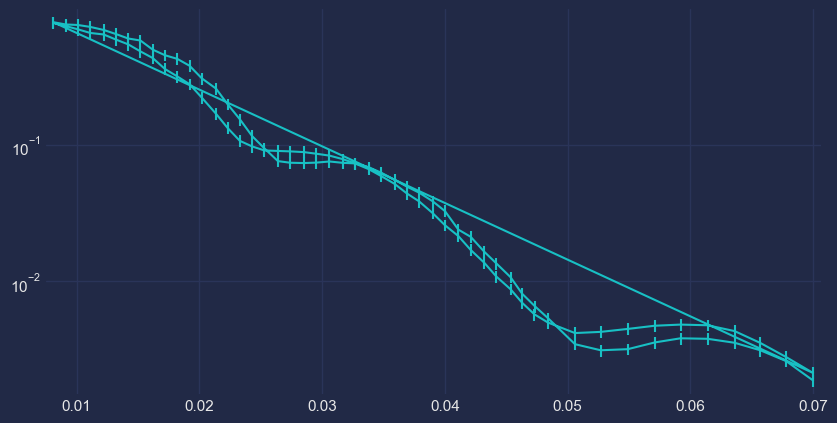

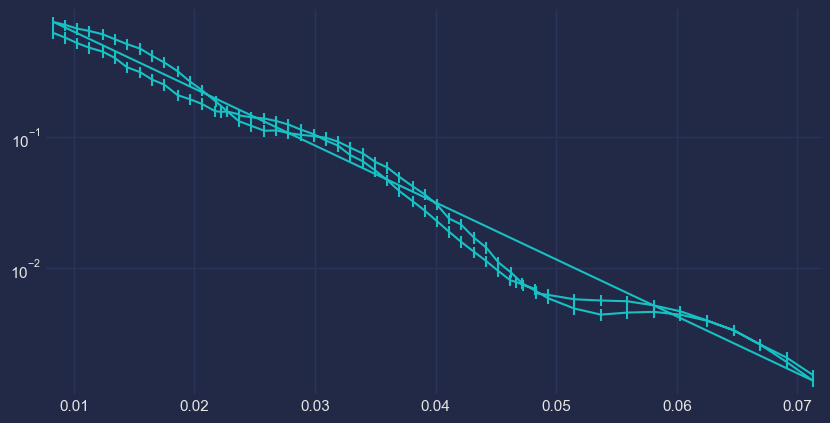

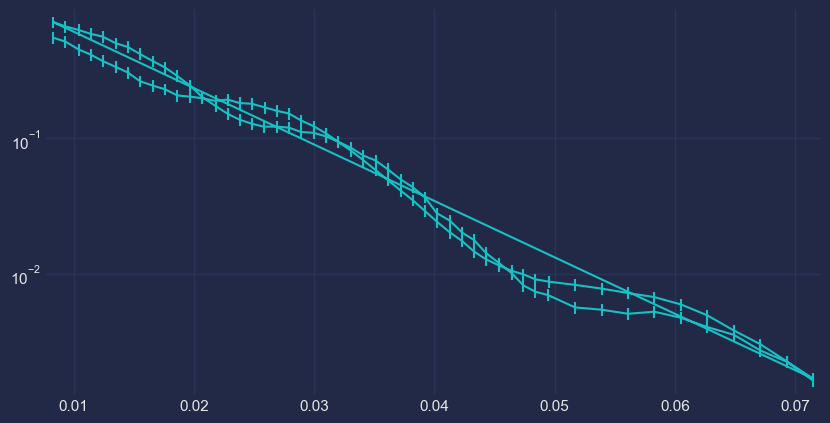

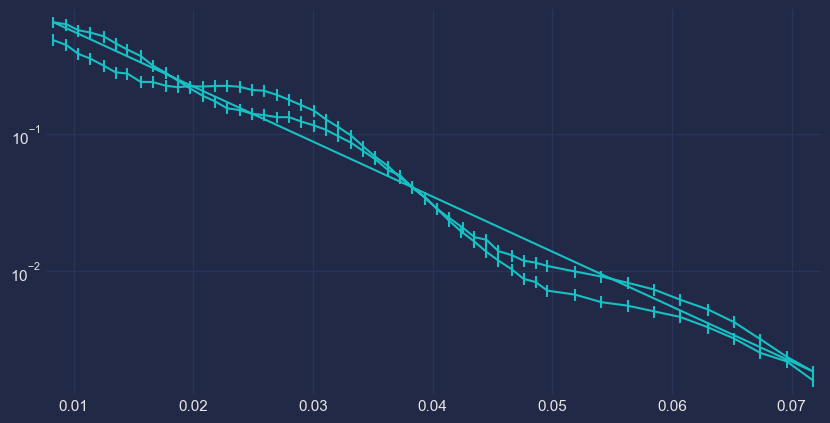

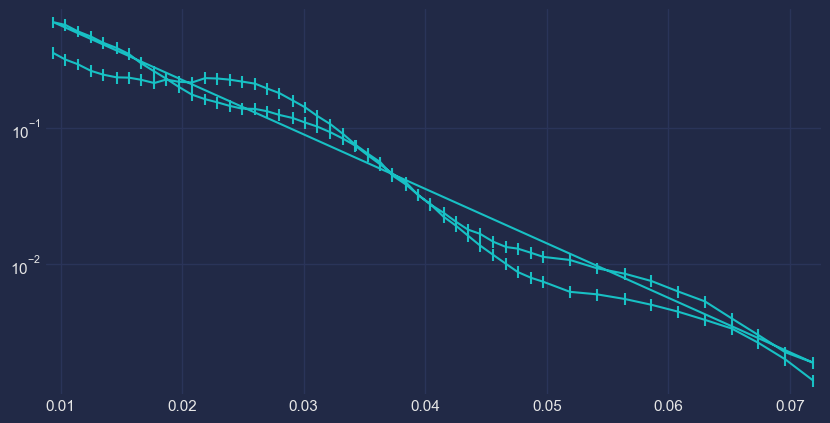

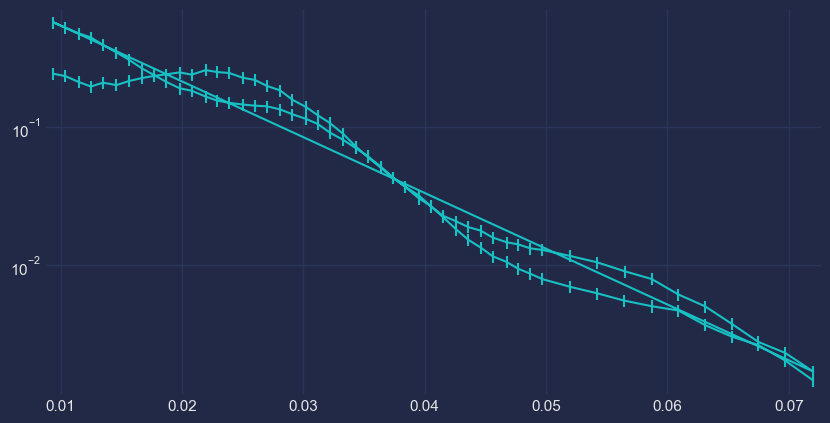

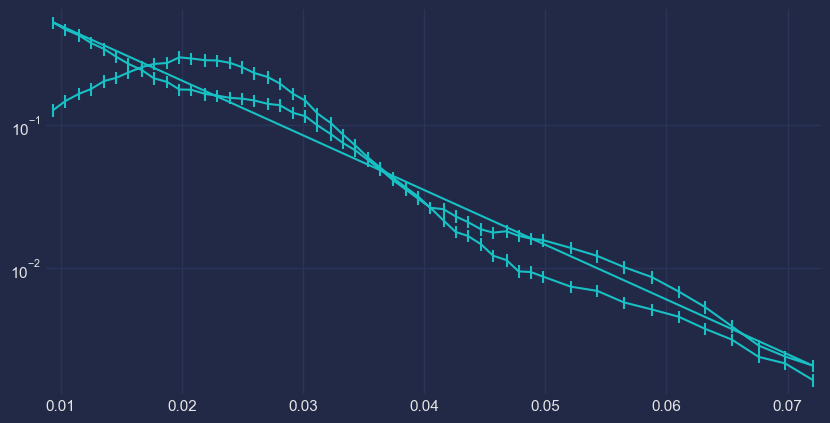

In [310]:
znpc_mono_series = []

for i, en in enumerate(ens):
    cutoff = 7 if i <= 3 else 8
    s = znpc_mono[f"{en}"]["s"].iloc[cutoff:]
    p = znpc_mono[f"{en}"]["p"].iloc[cutoff:]
    refl_data = rf.to_refnx_dataset(s, pol = "sp", second_pol=p)
    refl_data.plot()
    plt.yscale("log")
    znpc_mono_series.append(refl_data)

In [290]:
print(znpc_oc["xx"].n(281))
oc_res.loc[oc_res["energy"] == "281", "zz"]

(0.0009193269123370804+0.00023118639358234467j)


3    0.0
Name: zz, dtype: float64

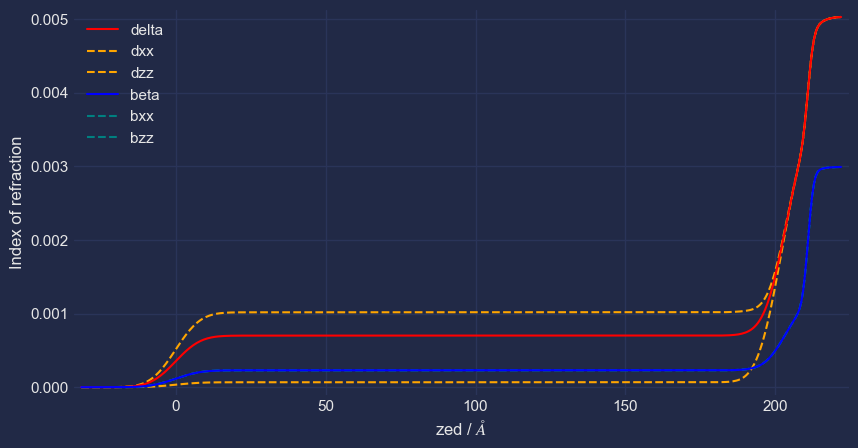

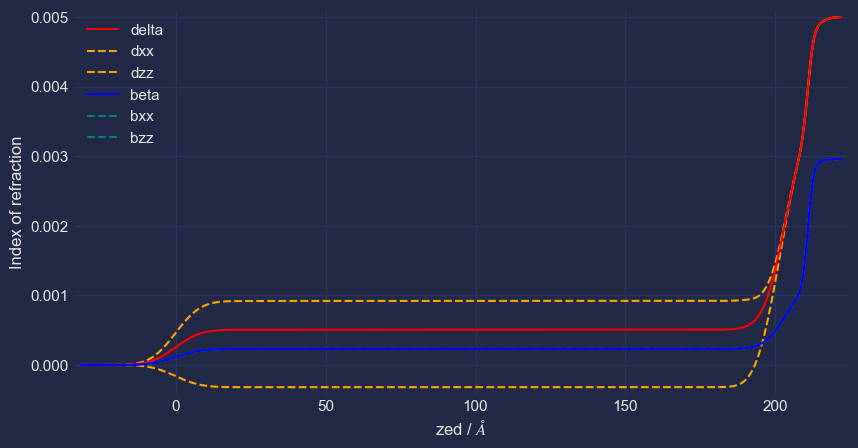

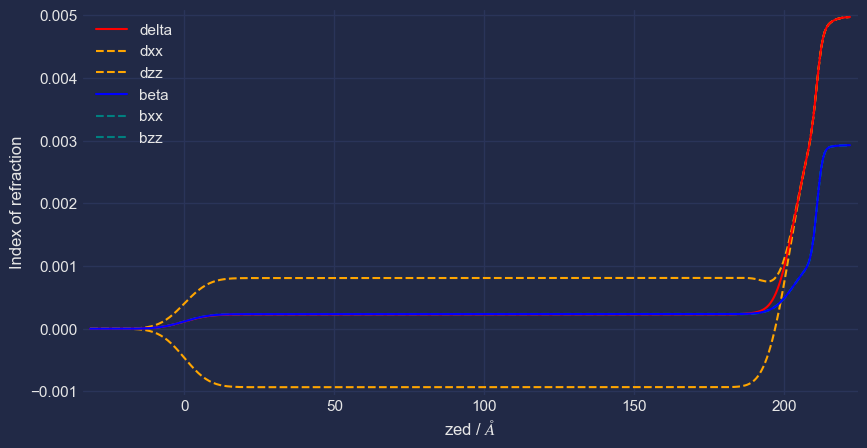

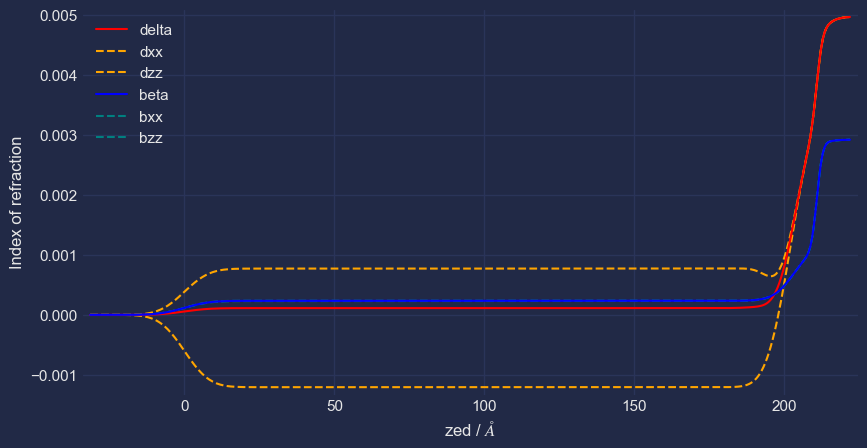

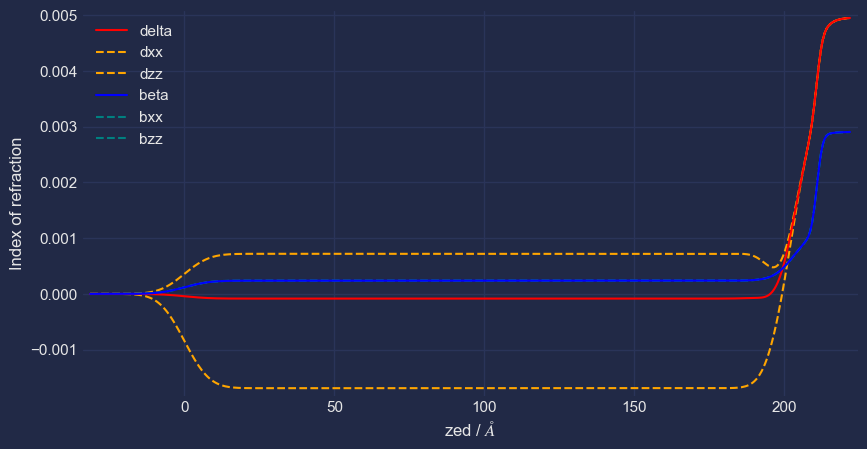

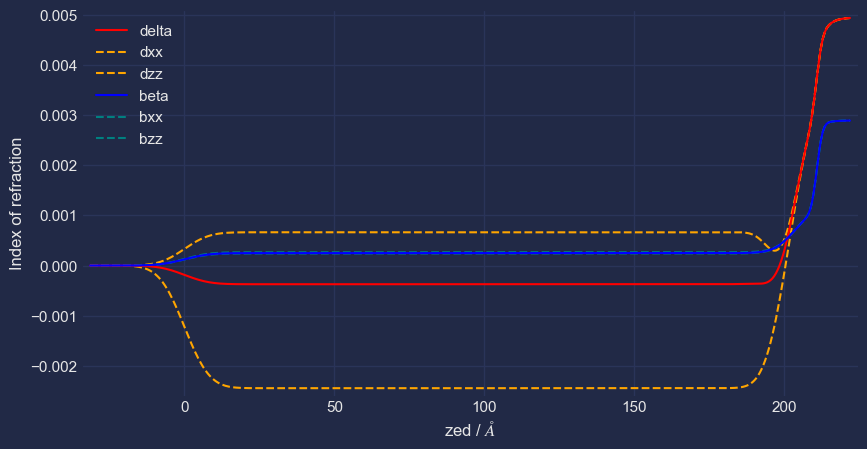

In [291]:
vac = [PXR_MaterialSLD("", 0, en)(0, 0) for en in ens]
si_2 = [PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough) for en in ens]
sio2_2 = [PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough) for en in ens]
c_amor_2 = [PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough) for en in ens]

znpc_2 = [PXR_SLD(np.array([znpc_oc["xx"].n(en), znpc_oc["zz"].n(en)]), symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough) for en in ens]

structs = [vac[i] | znpc_2[i] | c_amor_2[i] | sio2_2[i] | si_2[i] for i in range(len(ens))]

for struc in structs:
    struc.plot()

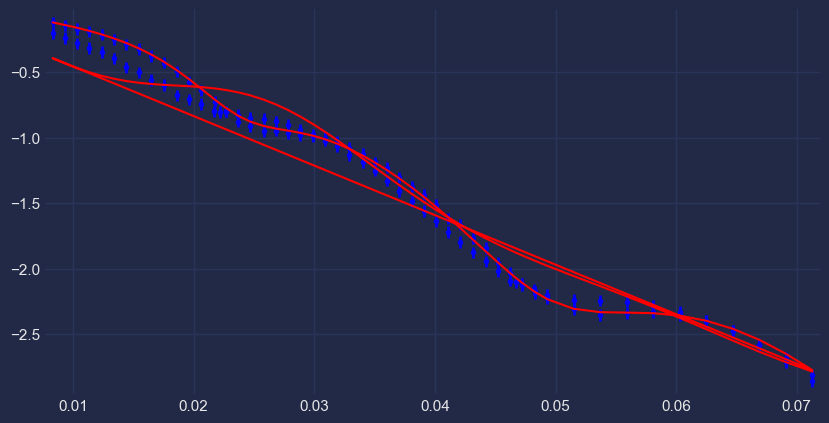

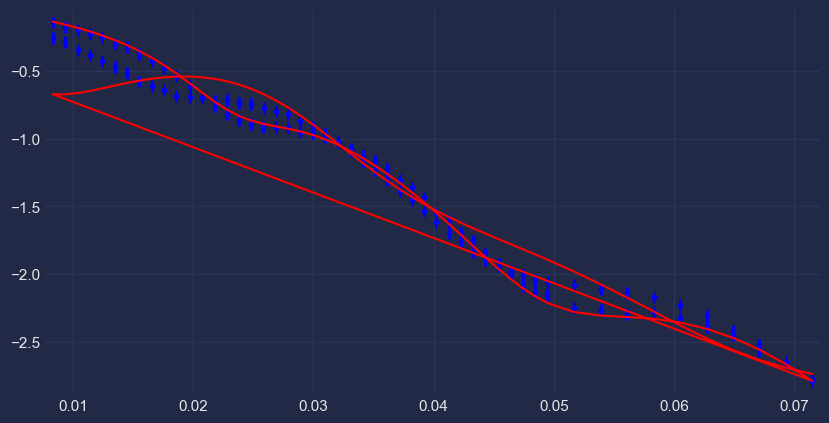

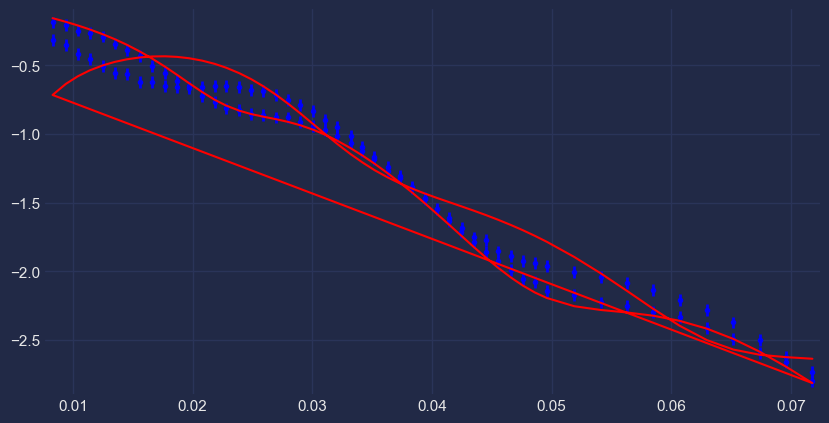

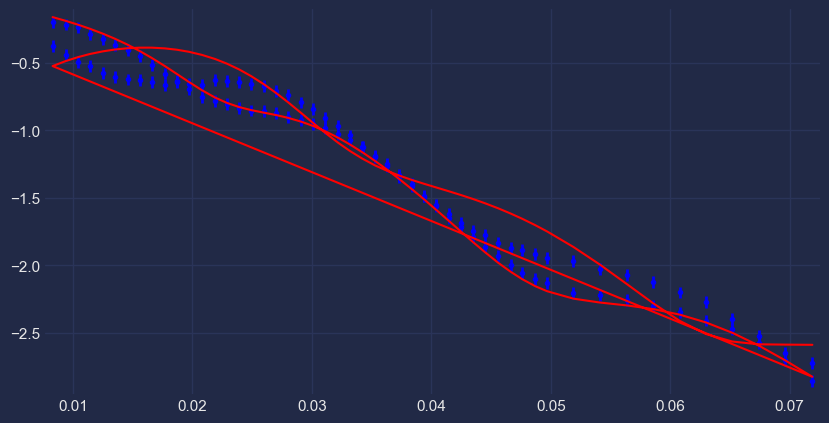

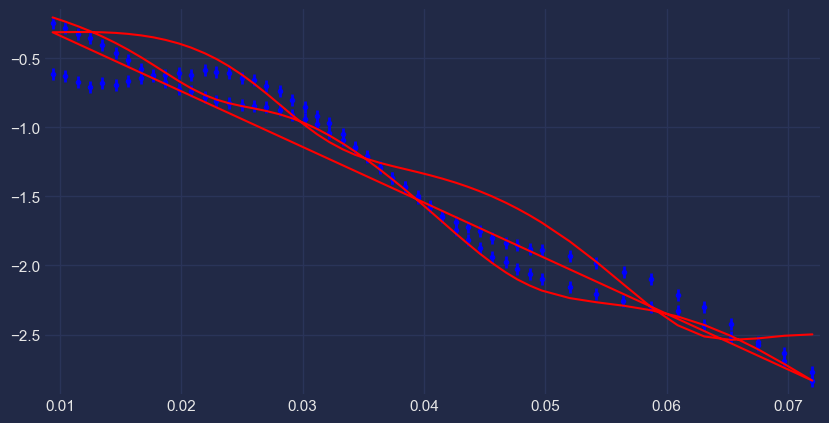

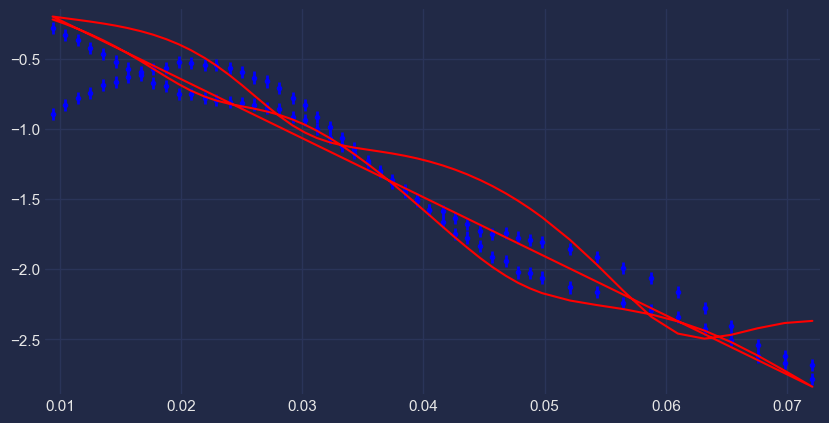

In [292]:
models = [PXR_ReflectModel(structs[i], pol = "sp", energy = ens[i], name = "ZnPc Mono Layer " + str(ens[i]) + "eV") for i in range(len(ens))]

for model in models:
    model.scale.setp(vary = True, bounds = (0.6, 1.2))
    model.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

objs = [Objective(models[i], znpc_mono_series[i], transform=Transform("logY")) for i in range(len(ens))]
for obj in objs:
    logp = LogpExtra_rough(obj)
    obj.logp_extra = logp

global_obj = GlobalObjective(objs)

for obj in objs:
    obj.plot()

### 280 eV

In [293]:
si_2[0].thick.setp(vary = False)
si_2[0].rough.setp(vary = False)

sio2_2[0].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[0].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[0].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[0].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[0].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[0].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[0].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[0].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[0].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[0].sld.delta.setp(vary = True, bounds = (-.0001,.002))

znpc_2[0].sld.xx.setp(vary = True, bounds = (znpc_2[0].sld.delta, .002))
znpc_2[0].sld.zz.setp(vary = True, bounds = (-.0001, znpc_2[0].sld.delta))
znpc_2[0].sld.ixx.setp(vary = None, constraint = znpc_2[0].sld.beta)
znpc_2[0].sld.izz.setp(vary = None, constraint = znpc_2[0].sld.beta)

100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.951573 +/- 0.0184, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.29682e-07 +/- 2.91e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000980198 +/- 0.000648, bounds=[-0.0001, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000237094 +/- 1.18e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000732874 +/- 2.97e-05, bounds=[0.0007001495016958878, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000695671 +/- 7.08e-06, bounds=[-0.0001, 0.0007001495016958878]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

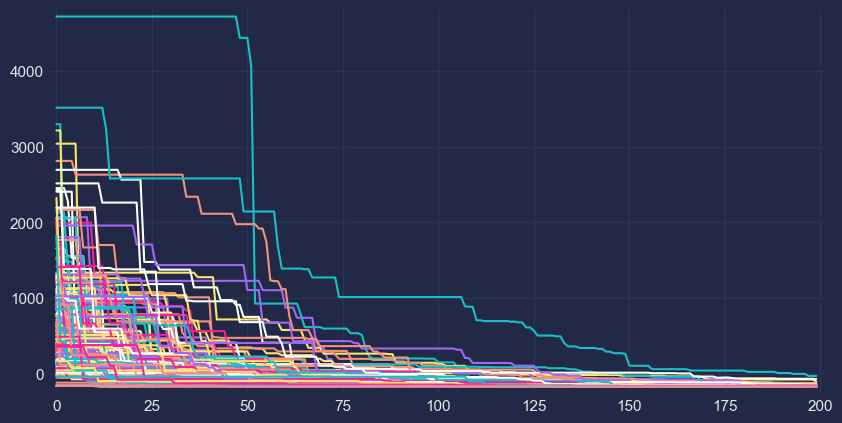

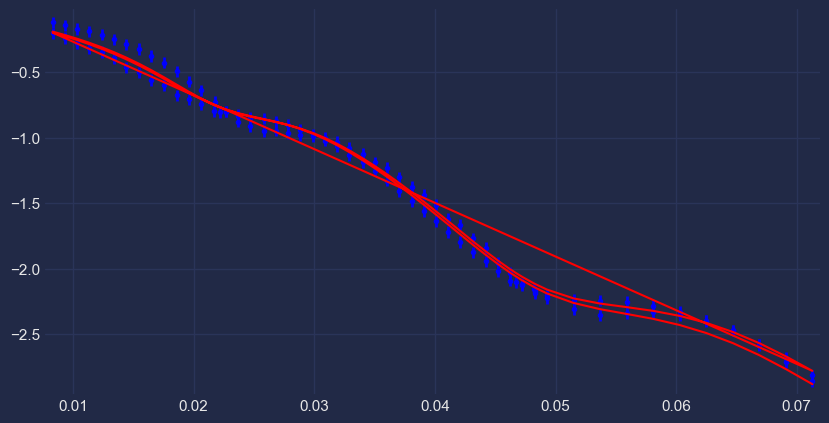

In [294]:
fitter_280 = CurveFitter(objs[0], nwalkers=nwalkers, moves = move)
fitter_280.initialise("prior")
chain_280 = fitter_280.sample(int(nwalkers), random_state=random_state)
lp_280 = fitter_280.logpost
plt.plot(-lp_280)

fitter_280.initialise("jitter")
chain_280 = fitter_280.sample(int(nwalkers), random_state=random_state)
lp_280 = fitter_280.logpost
plt.plot(-lp_280)

print(objs[0].varying_parameters())
objs[0].plot()

In [295]:
print(ens)

[280, 281, 282, 282.3, 282.7, 283.1]


In [296]:
import json


to_json(structs[0], db.res / "ZnPc_280eV_struct.json")
to_json(objs[0], db.res / "ZnPc_280eV_obj.json")



model_280_s = PXR_ReflectModel(structs[0], pol = "s", energy = ens[0], name = "ZnPc Mono Layer 280eV")(q)
model_280_p = PXR_ReflectModel(structs[0], pol = "p", energy = ens[0], name = "ZnPc Mono Layer 280eV")(q)

np.savetxt(db.res / "ZnPc_280eV_s_fit.txt", np.row_stack([q, model_280_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_280eV_p_fit.txt", np.row_stack([q, model_280_p]), delimiter = ",")

oc_res.loc[oc_res["energy"] == "280", "xx"] = znpc_2[0].sld.xx.value
oc_res.loc[oc_res["energy"] == "280", "zz"] = znpc_2[0].sld.zz.value
oc_res.loc[oc_res["energy"] == "280", "dxx"] = znpc_2[0].sld.xx.stderr
oc_res.loc[oc_res["energy"] == "280", "dzz"] = znpc_2[0].sld.zz.stderr
oc_res.loc[oc_res["energy"] == "280", "delta"] = znpc_2[0].sld.delta.value
oc_res.loc[oc_res["energy"] == "280", "ddelta"] = znpc_2[0].sld.delta.stderr
oc_res.loc[oc_res["energy"] == "280", "ixx"] = znpc_2[0].sld.ixx.value
oc_res.loc[oc_res["energy"] == "280", "izz"] = znpc_2[0].sld.izz.value
oc_res.loc[oc_res["energy"] == "280", "dixx"] = znpc_2[0].sld.ixx.stderr
oc_res.loc[oc_res["energy"] == "280", "dizz"] = znpc_2[0].sld.izz.stderr
oc_res.loc[oc_res["energy"] == "280", "beta"] = znpc_2[0].sld.beta.value
oc_res.loc[oc_res["energy"] == "280", "dbeta"] = znpc_2[0].sld.beta.stderr


oc_res

c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:115: RuntimeWarning: invalid value encountered in arcsin
  theta_exp = np.pi/2 - np.arcsin(flatq[:]  / (2*k0))
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:196: RuntimeWarning: invalid value encountered in sqrt
  kz_ord = np.sqrt(e_o * k0**2 - k_par[:]**2)#, dtype=np.complex128)
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:240: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv [:,:,None]#(np.linalg.norm(kvec,axis=-1)[:,:,None])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:251: RuntimeWarning: invalid value encountered in divide
  dpol_temp[:,0,:] = np.subtract(opticaxis[None, :], ((1 + nu)/(1+nu*kpol[:, 0, None]**2))*kpol[:, 0, None] * knorm[:, 0, :])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:252: RuntimeWarning: invalid value encountered

xx        zz       dxx       dzz     delta    ddelta       ixx  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.001267  0.001211  0.000059  0.000109  0.001199  0.000584  0.000293   
2  0.000733  0.000696  0.000030  0.000007  0.000980  0.000648  0.000237   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        izz      dixx      dizz      beta     dbeta energy  
0  0.000000  0.000000  0.000000  0.000000  0.000000    250  
1  0.000293  0.000042  0.000042  0.000293  0.000042    275  
2  0.000237  0.000012  0.000012  0.000237  0.000012    280  
3  0.000000  0.000000  0.000000  0.000000  0.000000    281  
4  0.000000  0.000000  0.000000  0.000000  0.000000    282  
5  0.000000  0.000000  0.000000  0.000000  0.000000  282.3  
6  0.000000  0.000000  0.000000  0.000000  0.000000  282.7  
7  0.000000  0.000000  0.000000  0.000000  0.000000  283.1  
8  0.000000  0.000000  0.000000  0.000000  0.000000  283.7  
9  0.000000  0.000000  0.000000  0.000000  0.000000  284.1

### 281 eV

In [297]:
si_2[1].thick.setp(vary = False)
si_2[1].rough.setp(vary = False)

sio2_2[1].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[1].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[1].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[1].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[1].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[1].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[1].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[1].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[1].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[1].sld.delta.setp(vary = True, bounds = (-.001,.002))

znpc_2[1].sld.xx.setp(vary = True, bounds = (znpc_2[1].sld.delta, .002))
znpc_2[1].sld.zz.setp(vary = True, bounds = (-.001, znpc_2[1].sld.delta))
znpc_2[1].sld.ixx.setp(vary = None, constraint = znpc_2[1].sld.beta)
znpc_2[1].sld.izz.setp(vary = None, constraint = znpc_2[1].sld.beta)

100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.05148 +/- 0.0289, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.90342e-07 +/- 2.97e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000403802 +/- 0.000777, bounds=[-0.001, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000258254 +/- 1.52e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000518187 +/- 2.4e-05, bounds=[0.0005066260315914997, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000501954 +/- 1.49e-05, bounds=[-0.001, 0.0005066260315914997]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

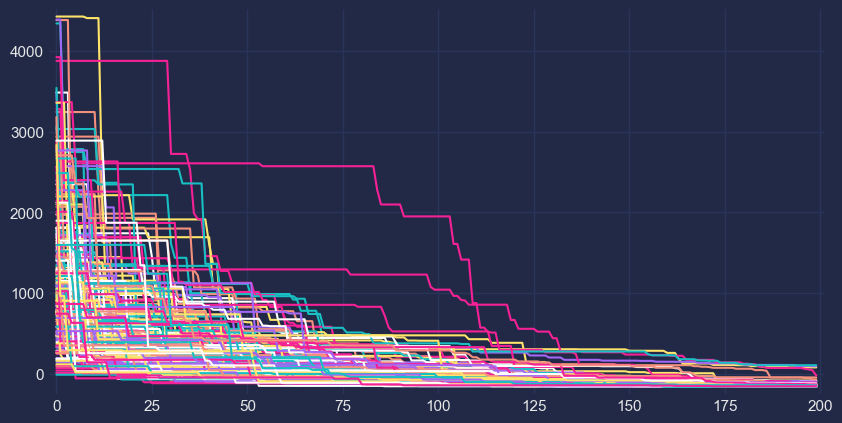

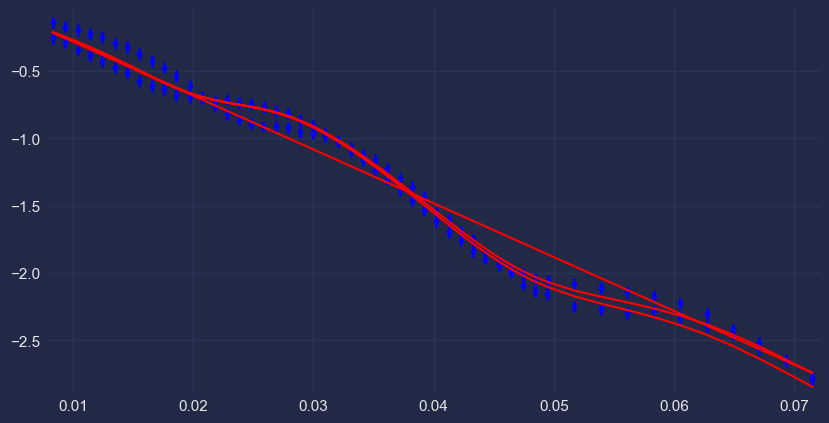

In [298]:
fitter_281 = CurveFitter(objs[1], nwalkers=nwalkers, moves = move)
fitter_281.initialise("prior")
chain_281 = fitter_281.sample(int(nwalkers), random_state=random_state)
lp_281 = fitter_281.logpost
plt.plot(-lp_281)

fitter_281.initialise("jitter")
chain_281 = fitter_281.sample(int(nwalkers), random_state=random_state)
lp_281 = fitter_281.logpost

print(objs[1].varying_parameters())
objs[1].plot()

In [299]:
to_json(structs[1], db.res / "ZnPc_281eV_struct.json")
to_json(objs[1], db.res / "ZnPc_281eV_obj.json")

model_281_s = PXR_ReflectModel(structs[1], pol = "s", energy = ens[1], name = "ZnPc Mono Layer 281eV")(q)
model_281_p = PXR_ReflectModel(structs[1], pol = "p", energy = ens[1], name = "ZnPc Mono Layer 281eV")(q)

np.savetxt(db.res / "ZnPc_281eV_s_fit.txt", np.row_stack([q, model_281_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_281eV_p_fit.txt", np.row_stack([q, model_281_p]), delimiter = ",")

c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:115: RuntimeWarning: invalid value encountered in arcsin
  theta_exp = np.pi/2 - np.arcsin(flatq[:]  / (2*k0))
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:196: RuntimeWarning: invalid value encountered in sqrt
  kz_ord = np.sqrt(e_o * k0**2 - k_par[:]**2)#, dtype=np.complex128)
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:240: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv [:,:,None]#(np.linalg.norm(kvec,axis=-1)[:,:,None])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:251: RuntimeWarning: invalid value encountered in divide
  dpol_temp[:,0,:] = np.subtract(opticaxis[None, :], ((1 + nu)/(1+nu*kpol[:, 0, None]**2))*kpol[:, 0, None] * knorm[:, 0, :])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:252: RuntimeWarning: invalid value encountered

### 282 eV

In [300]:
si_2[2].thick.setp(vary = False)
si_2[2].rough.setp(vary = False)

sio2_2[2].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[2].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[2].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[2].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[2].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[2].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[2].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[2].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[2].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[2].sld.delta.setp(vary = True, bounds = (-.001,.002))

znpc_2[2].sld.xx.setp(vary = True, bounds = (znpc_2[2].sld.delta, .002))
znpc_2[2].sld.zz.setp(vary = True, bounds = (-.002, znpc_2[2].sld.delta))
znpc_2[2].sld.ixx.setp(vary = None, constraint = znpc_2[2].sld.beta)
znpc_2[2].sld.izz.setp(vary = None, constraint = znpc_2[2].sld.beta)

100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.07716 +/- 0.0343, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.23478e-07 +/- 2.96e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000435712 +/- 0.000837, bounds=[-0.001, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.00023552 +/- 1.69e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000243827 +/- 3.57e-05, bounds=[0.00022777608805737713, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000223503 +/- 2.21e-05, bounds=[-0.002, 0.00022777608805737713]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

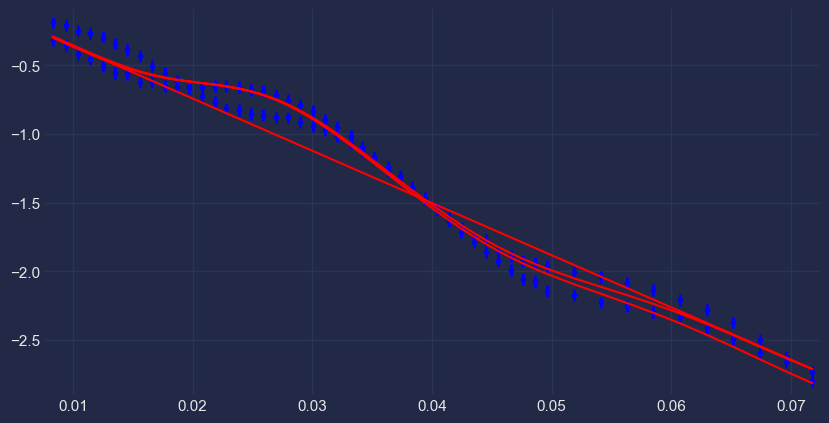

In [301]:
fitter_282 = CurveFitter(objs[2], nwalkers=nwalkers, moves = move)
fitter_282.initialise("prior")
chain_282 = fitter_282.sample(int(nwalkers), random_state=random_state)

fitter_282.initialise("jitter")
chain_282 = fitter_282.sample(int(nwalkers), random_state=random_state)
lp_282 = fitter_282.logpost

print(objs[2].varying_parameters())
objs[2].plot()

In [302]:
to_json(structs[2], db.res / "ZnPc_282eV_struct.json")
to_json(objs[2], db.res / "ZnPc_282eV_obj.json")

model_282_s = PXR_ReflectModel(structs[2], pol = "s", energy = ens[2], name = "ZnPc Mono Layer 282eV")(q)
model_282_p = PXR_ReflectModel(structs[2], pol = "p", energy = ens[2], name = "ZnPc Mono Layer 282eV")(q)

np.savetxt(db.res / "ZnPc_282eV_s_fit.txt", np.row_stack([q, model_282_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_282eV_p_fit.txt", np.row_stack([q, model_282_p]), delimiter = ",")

### 282.3

In [303]:
si_2[3].thick.setp(vary = False)
si_2[3].rough.setp(vary = False)

sio2_2[3].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[3].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[3].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[3].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[3].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[3].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[3].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[3].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[3].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[3].sld.delta.setp(vary = True, bounds = (-.002,.002))

znpc_2[3].sld.xx.setp(vary = True, bounds = (znpc_2[3].sld.delta, .002))
znpc_2[3].sld.zz.setp(vary = True, bounds = (-.002, znpc_2[3].sld.delta))
znpc_2[3].sld.ixx.setp(vary = None, constraint = znpc_2[3].sld.beta)
znpc_2[3].sld.izz.setp(vary = None, constraint = znpc_2[3].sld.beta)

100%|██████████| 200/200 [00:16<00:00, 12.11it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.02619 +/- 0.0379, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.17947e-07 +/- 2.99e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000136708 +/- 0.00103, bounds=[-0.002, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000216001 +/- 1.91e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000132472 +/- 3.56e-05, bounds=[0.0001124709313397924, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000101753 +/- 5.68e-05, bounds=[-0.002, 0.0001124709313397924]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

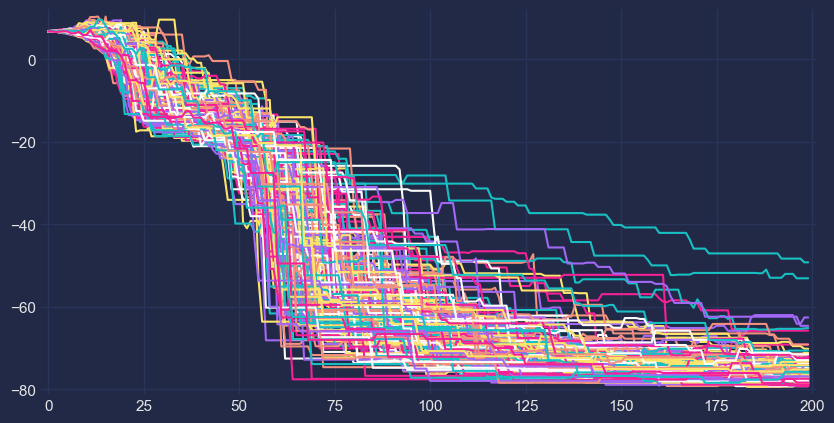

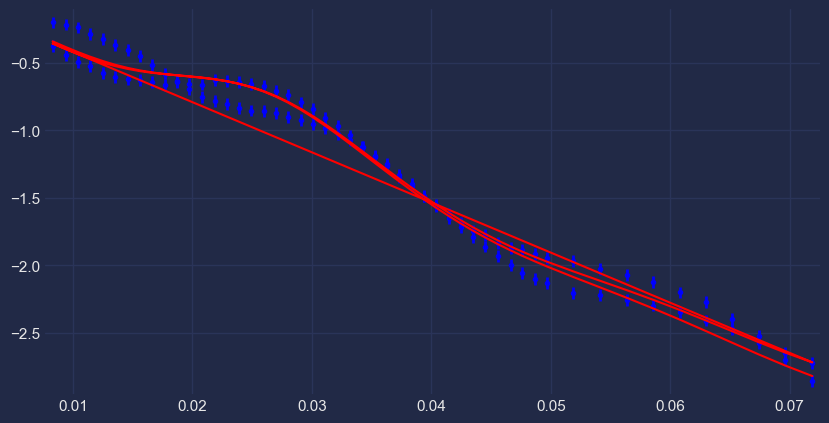

In [304]:
fitter_282p3 = CurveFitter(objs[3], nwalkers=nwalkers, moves = move)
fitter_282p3.initialise("prior")
chain_282p3 = fitter_282p3.sample(int(nwalkers), random_state=random_state)

fitter_282p3.initialise("jitter")
chain_282p3 = fitter_282p3.sample(int(nwalkers), random_state=random_state)
lp_282p3 = fitter_282p3.logpost
plt.plot(-lp_282p3)

print(objs[3].varying_parameters())
objs[3].plot()

In [305]:
to_json(structs[3], db.res / "ZnPc_282.3eV_struct.json")
to_json(objs[3], db.res / "ZnPc_282.3eV_obj.json")

model_282p3_s = PXR_ReflectModel(structs[3], pol = "s", energy = ens[3], name = "ZnPc Mono Layer 282.3eV")(q)
model_282p3_p = PXR_ReflectModel(structs[3], pol = "p", energy = ens[3], name = "ZnPc Mono Layer 282.3eV")(q)

np.savetxt(db.res / "ZnPc_282.3eV_s_fit.txt", np.row_stack([q, model_282p3_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_282.3eV_p_fit.txt", np.row_stack([q, model_282p3_p]), delimiter = ",")

### 282.7

In [306]:
si_2[4].thick.setp(vary = False)
si_2[4].rough.setp(vary = False)

sio2_2[4].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[4].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[4].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[4].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[4].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[4].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[4].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[4].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[4].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[4].sld.delta.setp(vary = True, bounds = (-.003,.002))

znpc_2[4].sld.xx.setp(vary = True, bounds = (znpc_2[4].sld.delta, .002))
znpc_2[4].sld.zz.setp(vary = True, bounds = (-.003, znpc_2[4].sld.delta))
znpc_2[4].sld.ixx.setp(vary = None, constraint = znpc_2[4].sld.beta)
znpc_2[4].sld.izz.setp(vary = None, constraint = znpc_2[4].sld.beta)

In [307]:
fitter_282p7 = CurveFitter(objs[4], nwalkers=nwalkers, moves = move)
fitter_282p7.initialise("prior")
chain_282p7 = fitter_282p7.sample(int(nwalkers), random_state=random_state)

fitter_282p7.initialise("jitter")
chain_282p7 = fitter_282p7.sample(int(nwalkers), random_state=random_state)
lp_282p7 = fitter_282p7.logpost
plt.plot(-lp_282p7)

print(objs[4].varying_parameters())
objs[4].plot()

100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


KeyboardInterrupt: 

In [ ]:
to_json(structs[4], db.res / "ZnPc_282.7eV_struct.json")
to_json(objs[4], db.res / "ZnPc_282.7eV_obj.json")

model_282p7_s = PXR_ReflectModel(structs[4], pol = "s", energy = ens[4], name = "ZnPc Mono Layer 282.7eV")(q)
model_282p7_p = PXR_ReflectModel(structs[4], pol = "p", energy = ens[4], name = "ZnPc Mono Layer 282.7eV")(q)

np.savetxt(db.res / "ZnPc_282.7eV_s_fit.txt", np.row_stack([q, model_282p7_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_282.7eV_p_fit.txt", np.row_stack([q, model_282p7_p]), delimiter = ",")

### 283.1

In [ ]:
si_2[5].thick.setp(vary = False)
si_2[5].rough.setp(vary = False)

sio2_2[5].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[5].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[5].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[5].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[5].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[5].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[5].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[5].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[5].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[5].sld.delta.setp(vary = True, bounds = (-.003,.002))

znpc_2[5].sld.xx.setp(vary = True, bounds = (znpc_2[5].sld.delta, .002))
znpc_2[5].sld.zz.setp(vary = True, bounds = (-.003, znpc_2[5].sld.delta))
znpc_2[5].sld.ixx.setp(vary = True, bounds = (-.003, .002))
znpc_2[5].sld.izz.setp(vary = True, bounds = (-.003, .002))

100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.16524 +/- 0.122, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.75956e-07 +/- 2.91e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=-0.000430629 +/- 0.00123, bounds=[-0.003, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000239965 +/- 0.000141, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=-0.000406245 +/- 0.000233, bounds=[-0.003, 0.002]>
<Parameter:  'ZnPc_ixx'   , value=0.000309083 +/- 4.07e-05, bounds=[-0.003, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000389781 +/- 0.000412, bounds=[-0.003, 0.002]>
<Parameter:  'ZnPc_izz'   , value=0.00030336 +/- 5.41e-05, bounds=[-0.003, 0.002]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

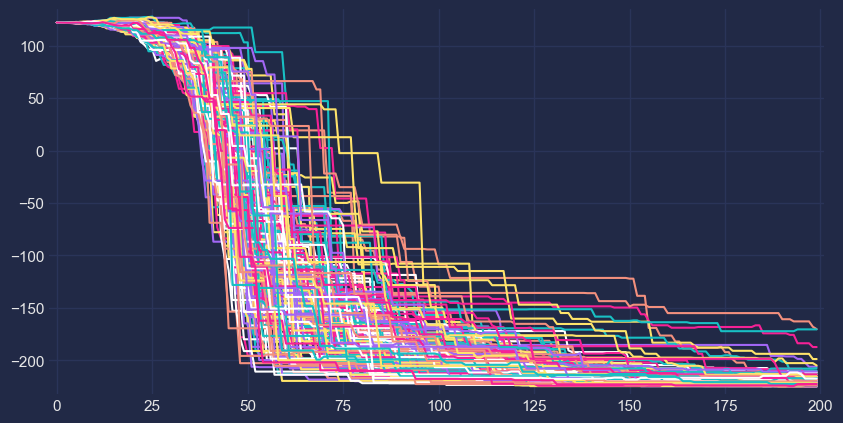

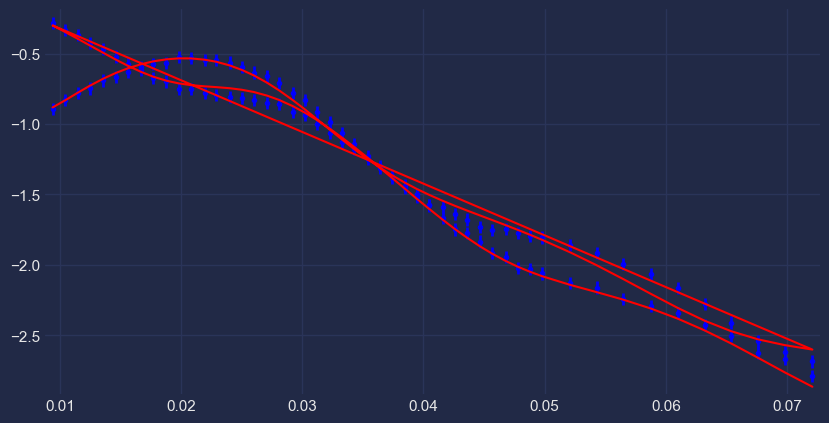

In [ ]:
fitter_283p1 = CurveFitter(objs[5], nwalkers=nwalkers, moves = move)
fitter_283p1.initialise("prior")
chain_283p1 = fitter_283p1.sample(int(nwalkers), random_state=random_state)

fitter_283p1.initialise("jitter")
chain_283p1 = fitter_283p1.sample(int(nwalkers), random_state=random_state)

lp_283p1 = fitter_283p1.logpost
plt.plot(-lp_283p1)

print(objs[5].varying_parameters())
objs[5].plot()

xx        zz       dxx       dzz     delta    ddelta       ixx  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.001244  0.001442  0.000072  0.000226  0.001222  0.000602  0.000325   
2  0.000749  0.000987  0.000027  0.000029  0.000995  0.000665  0.000285   
3  0.000464  0.000850  0.000026  0.000028  0.000446  0.000874  0.000313   
4  0.000230  0.000674  0.000026  0.000028  0.000445  0.000894  0.000300   
5  0.000126  0.000651  0.000025  0.000028 -0.000053  0.000993  0.000308   
6 -0.000061  0.000554  0.000031  0.000028 -0.000447  0.001352  0.000315   
7 -0.000406  0.000390  0.000233  0.000412 -0.000431  0.001225  0.000309   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        izz      dixx      dizz      beta     dbeta energy  
0  0.000000  0.000000  0.000000  0.000000  0.000000    250  
1  0.000325  0.000051  0.000051  0.000325  0.000051    275  
2  0.000285  0.000011  0.000011  0.000285  0.000011    280  
3  0.000313  0.000012  0.000012  0.000313  0.000012    281  
4  0.000300  0.000009  0.000009  0.000300  0.000009    282  
5  0.000308  0.000009  0.000009  0.000308  0.000009  282.3  
6  0.000315  0.000009  0.000009  0.000315  0.000009  282.7  
7  0.000303  0.000041  0.000054  0.000240  0.000141  283.1  
8  0.000000  0.000000  0.000000  0.000000  0.000000  283.7  
9  0.000000  0.000000  0.000000  0.000000  0.000000  284.1

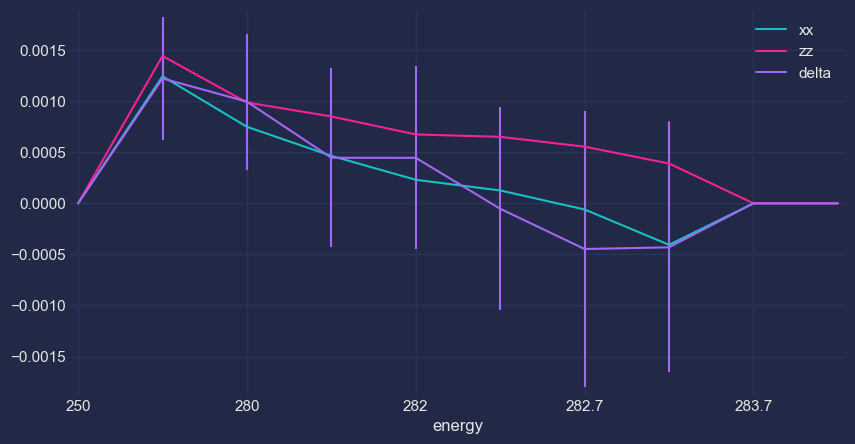

In [ ]:
for i,  en in enumerate(ens):
    oc_res.loc[oc_res["energy"] == str(en), "xx"] = znpc_2[i].sld.xx.value
    oc_res.loc[oc_res["energy"] == str(en), "zz"] = znpc_2[i].sld.zz.value
    oc_res.loc[oc_res["energy"] == str(en), "dxx"] = znpc_2[i].sld.xx.stderr
    oc_res.loc[oc_res["energy"] == str(en), "dzz"] = znpc_2[i].sld.zz.stderr
    oc_res.loc[oc_res["energy"] == str(en), "delta"] = znpc_2[i].sld.delta.value
    oc_res.loc[oc_res["energy"] == str(en), "ddelta"] = znpc_2[i].sld.delta.stderr
    oc_res.loc[oc_res["energy"] == str(en), "ixx"] = znpc_2[i].sld.ixx.value
    oc_res.loc[oc_res["energy"] == str(en), "izz"] = znpc_2[i].sld.izz.value
    oc_res.loc[oc_res["energy"] == str(en), "dixx"] = znpc_2[i].sld.ixx.stderr
    oc_res.loc[oc_res["energy"] == str(en), "dizz"] = znpc_2[i].sld.izz.stderr
    oc_res.loc[oc_res["energy"] == str(en), "beta"] = znpc_2[i].sld.beta.value
    oc_res.loc[oc_res["energy"] == str(en), "dbeta"] = znpc_2[i].sld.beta.stderr

fig, ax = plt.subplots()
display(oc_res)
oc_res.plot(x = "energy", y = "xx", yerr = "dxx", ax = ax)
oc_res.plot(x = "energy", y = "zz", yerr = "dzz", ax = ax)
oc_res.plot(x = "energy", y = "delta", yerr = "ddelta", ax = ax)


In [172]:
to_json(structs[5], db.res / "ZnPc_283.1eV_struct.json")
to_json(objs[5], db.res / "ZnPc_283.1eV_obj.json")

model_283p1_s = PXR_ReflectModel(structs[5], pol = "s", energy = ens[5], name = "ZnPc Mono Layer 283.1eV")(q)
model_283p1_p = PXR_ReflectModel(structs[5], pol = "p", energy = ens[5], name = "ZnPc Mono Layer 283.1eV")(q)

np.savetxt(db.res / "ZnPc_283.1eV_s_fit.txt", np.row_stack([q, model_283p1_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_283.1eV_p_fit.txt", np.row_stack([q, model_283p1_p]), delimiter = ",")

oc_res.to_csv(db.res / "ZnPc_OC.csv", index = False)

# Junk

100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.997307 +/- 0.0146, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.03536e-07 +/- 3.4e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000383594 +/- 2.61e-06, bounds=[3.348413000880585e-05, 0.0015251101838025388]>
<Parameter:  'ZnPc_biso'  , value=0.000229087 +/- 1.64e-06, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=6.70029e-05 +/- 6.45e-07, bounds=[3.348413000880585e-05, 0.0015251101838025388]>
<Parameter:   'ZnPc_zz'   , value=0.00101628 +/- 1.03e-05, bounds=[3.348413000880585e-05, 0.0015251101838025388]>
________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.00009 +/- 0.00577, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.77921e-07 +/- 3.39e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=9.39046e-

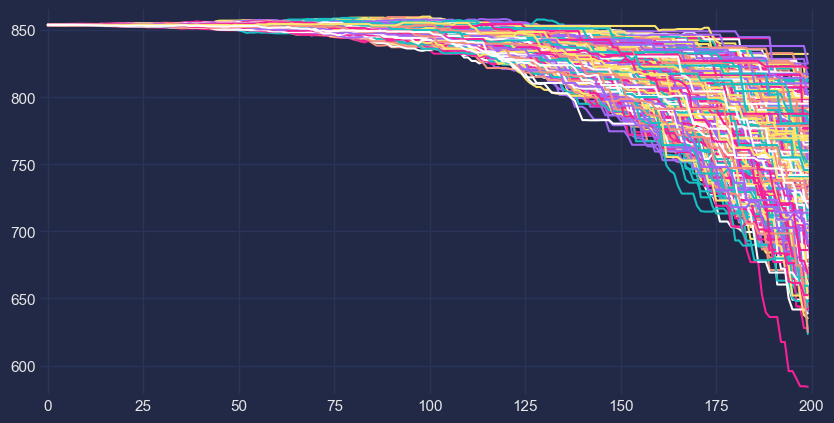

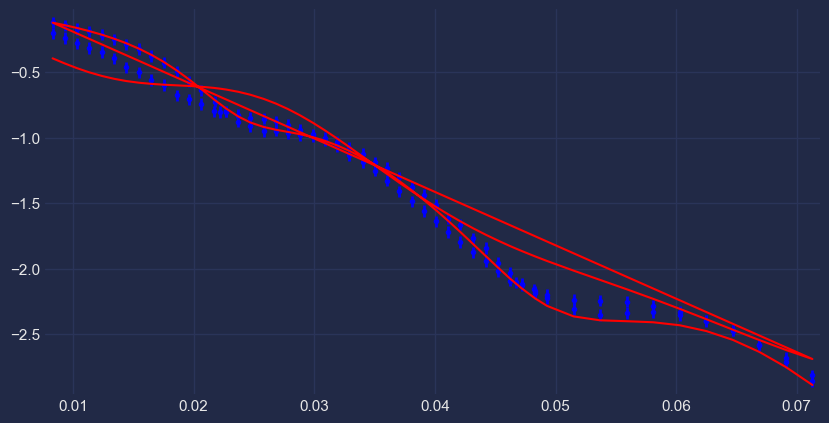

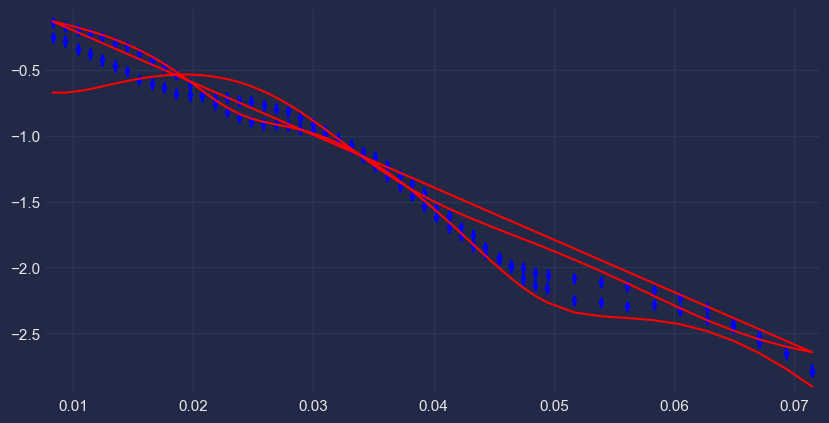

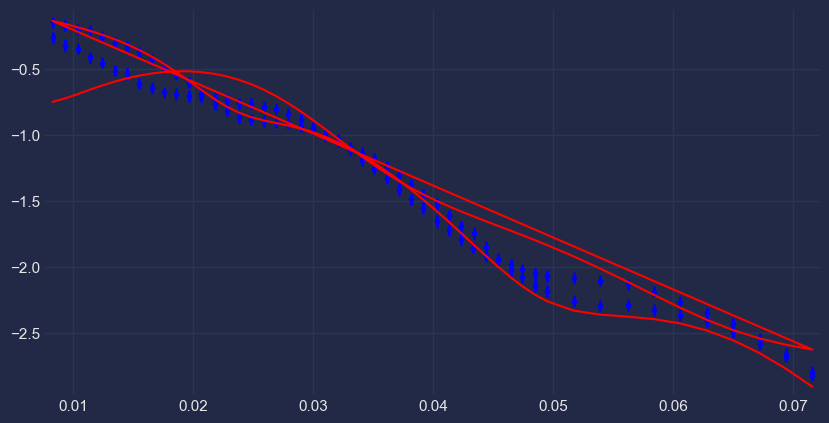

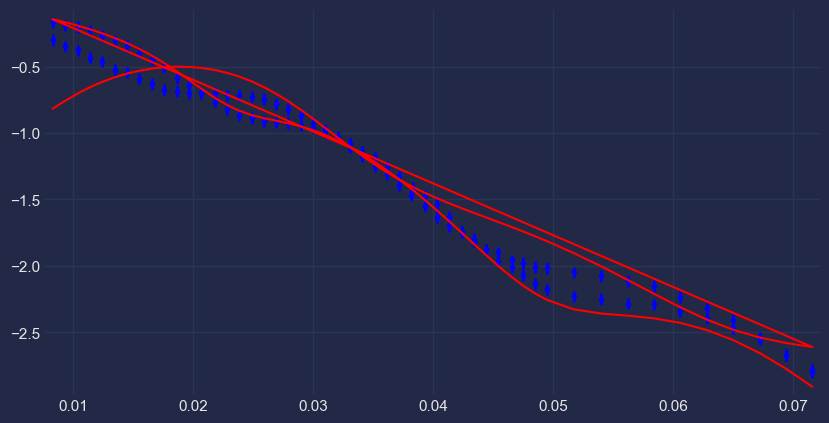

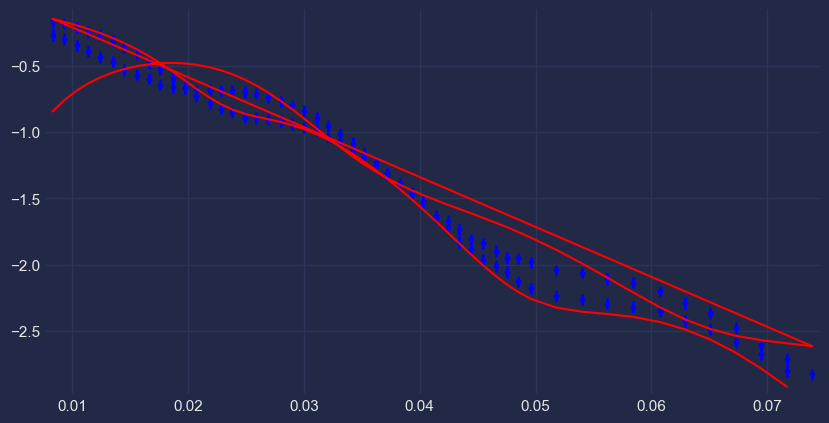

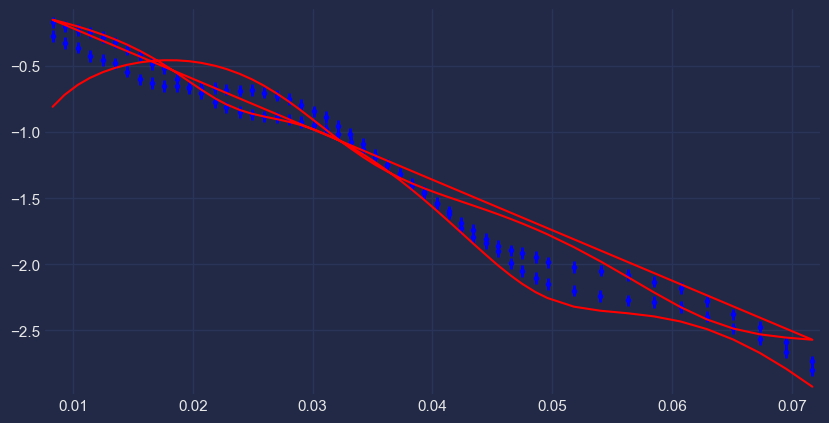

In [59]:
fitter_global = CurveFitter(global_obj, nwalkers=nwalkers * len(ens), moves = move)
fitter_global.initialise("jitter")
chain = fitter_global.sample(int(nwalkers), random_state=random_state)
lp = fitter_global.logpost
plt.plot(-lp)

for obj in objs:
    print(obj.varying_parameters())
    obj.plot()

## <a id='toc1_2_'></a>[Fit 283.7 eV Data](#toc0_)

### <a id='toc1_2_1_'></a>[Load the 283.7 eV data](#toc0_)

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

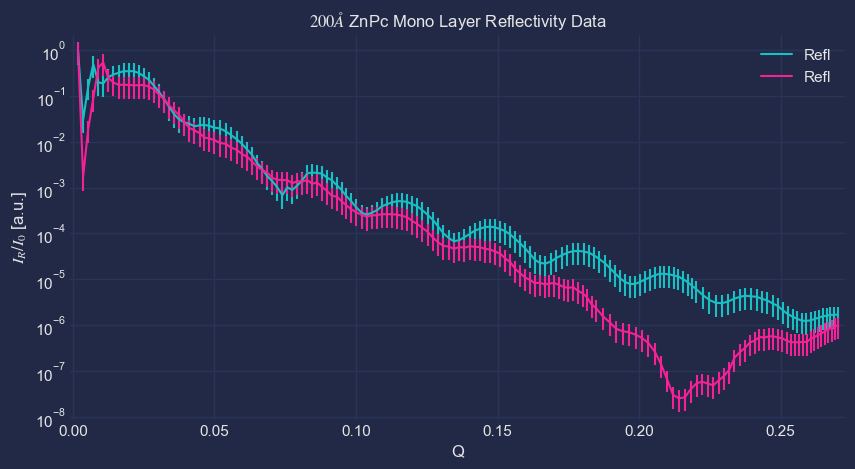

In [47]:
fig, ax = plt.subplots()

znpc_mono_283p7_s = znpc_mono["283.7"]["s"]
znpc_mono_283p7_p = znpc_mono["283.7"]["p"]

# Modify the error to 20 percent
scale = .5
znpc_mono_283p7_s["Err"] = znpc_mono_283p7_s["Refl"]*scale
znpc_mono_283p7_p["Err"] = znpc_mono_283p7_p["Refl"]*scale

znpc_mono_283p7_s.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

#### <a id='toc1_2_1_1_'></a>[Various Masking Attempts](#toc0_)

[Text(0.5, 0, 'Q [$\\AA^{-1}$]'), Text(0, 0.5, '$I_R / I_0$ [a.u.]'), None]

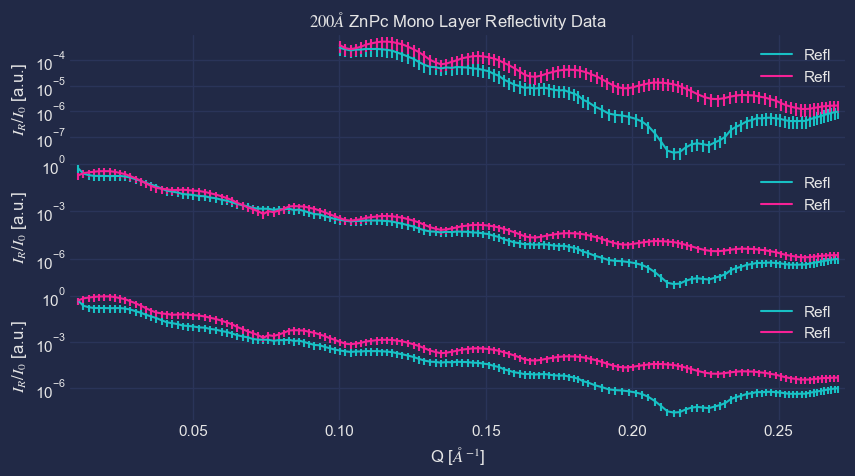

In [53]:
fig, ax = plt.subplots(nrows = 3, sharex=True, gridspec_kw={"hspace":0})
# (Extream Remove Low Q) Masking <.1

znpc_mono_283p7_s_extreme = znpc_mono_283p7_s[znpc_mono_283p7_s["Q"] > .1]
znpc_mono_283p7_p_extreme = znpc_mono_283p7_p[znpc_mono_283p7_p["Q"] > .1]

znpc_mono_283p7_p_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
ax[0].set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

znpc_mono_283p7_extreme = rf.to_refnx_dataset(znpc_mono_283p7_s_extreme, pol = "sp", second_pol=znpc_mono_283p7_p_extreme)

# (Remove Low Q) Masking first 5 points
znpc_mono_283p7_s_lowq = znpc_mono_283p7_s.iloc[5:]
znpc_mono_283p7_p_lowq = znpc_mono_283p7_p.iloc[5:]

znpc_mono_283p7_p_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
ax[1].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

znpc_mono_283p7_lowq = rf.to_refnx_dataset(znpc_mono_283p7_s_lowq, pol = "sp", second_pol=znpc_mono_283p7_p_lowq)

# (Remove Low Q + Scale)

znpc_mono_283p7_s_lowq_scale = znpc_mono_283p7_s_lowq.copy()
znpc_mono_283p7_p_lowq_scale = znpc_mono_283p7_p_lowq.copy()
scale = znpc_mono_283p7_p_lowq_scale["Refl"].iloc[0] / znpc_mono_283p7_s_lowq_scale["Refl"].iloc[0]
znpc_mono_283p7_s_lowq_scale["Refl"] *= scale
znpc_mono_283p7_s_lowq_scale["Err"] *= scale

znpc_mono_283p7_lowq_scale = rf.to_refnx_dataset(znpc_mono_283p7_s_lowq_scale, pol = "sp", second_pol=znpc_mono_283p7_p_lowq_scale)

znpc_mono_283p7_p_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
ax[2].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)


### <a id='toc1_2_2_'></a>[Construct the slab structure for the data](#toc0_)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

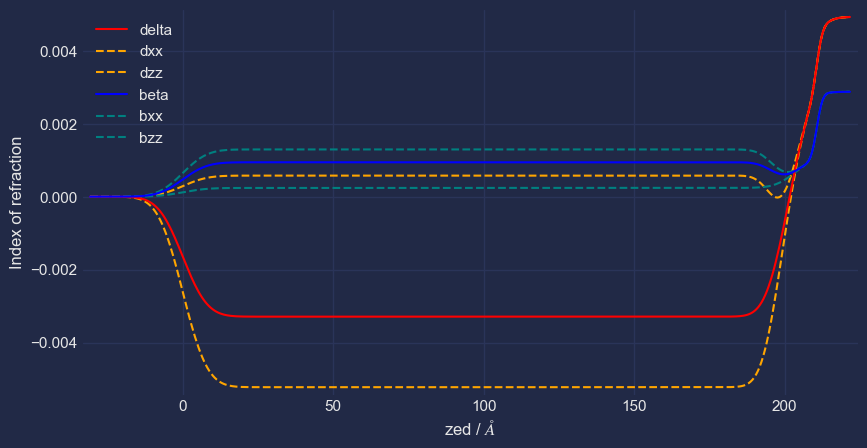

In [58]:
en = 283.7
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["zz"].n(en), znpc_oc["xx"].n(en)])

biref = znpc_oc["zz"].delta(en) - znpc_oc["xx"].delta(en)
dicrho = znpc_oc["zz"].beta(en) - znpc_oc["xx"].beta(en)

znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_283p7 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_283p7.plot()

### <a id='toc1_2_3_'></a>[Construct the Objective Function](#toc0_)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

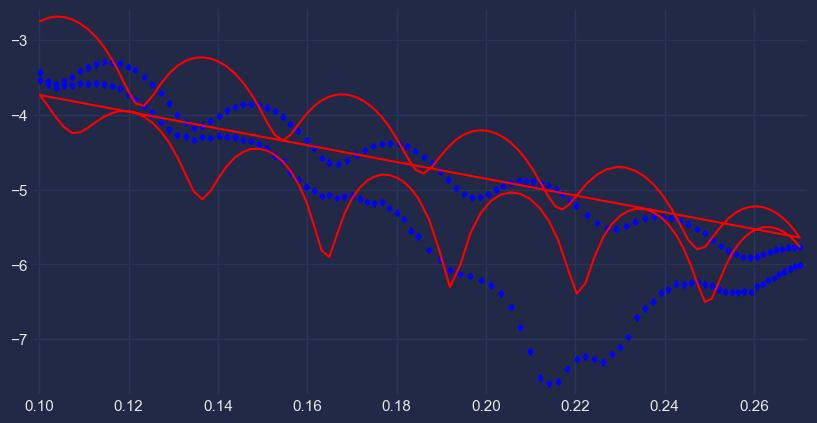

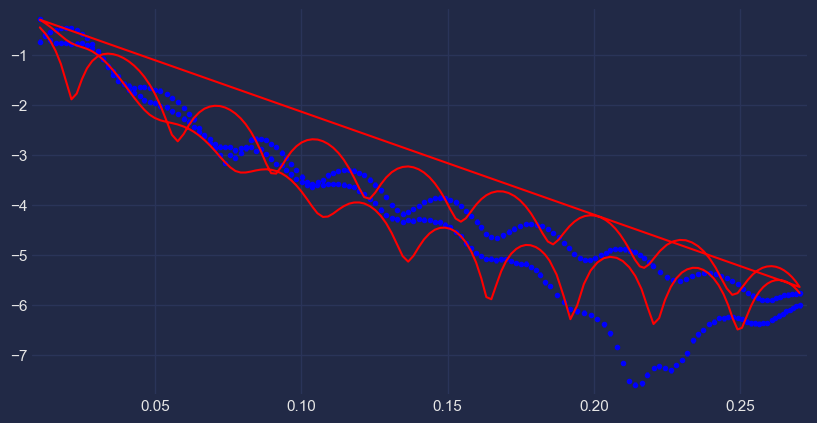

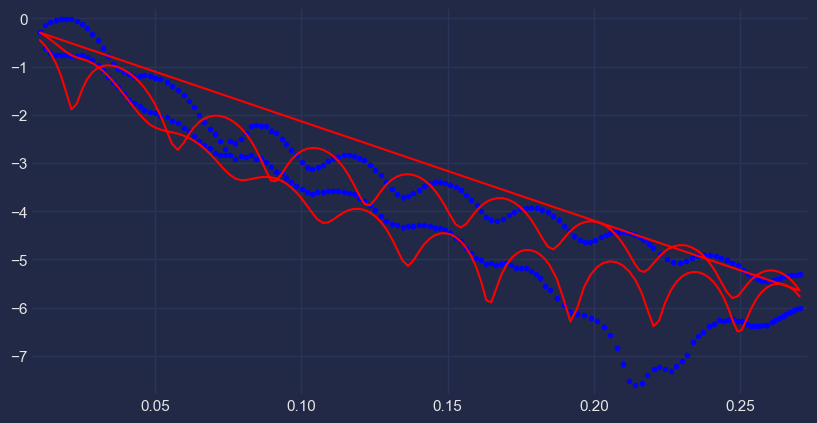

In [59]:
model_283p7 = PXR_ReflectModel(struct_283p7, pol = "sp", energy = en, name = "ZnPc Mono Layer 283p7eV")
model_283p7.scale.setp(vary = True, bounds = (0.6, 1.2))
model_283p7.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

# Low q masking
from pyref.fitting.logp import LogpExtra_rough
obj_283p7_lowq = Objective(model_283p7, znpc_mono_283p7_extreme, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_lowq)
obj_283p7_lowq.logp_extra = logp

obj_283p7_lowq.plot()

# extream q masking
obj_283p7_extreme = Objective(model_283p7, znpc_mono_283p7_lowq, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_extreme)
obj_283p7_extreme.logp_extra = logp

obj_283p7_extreme.plot()

# Low q masking + scale
obj_283p7_lowq_scale = Objective(model_283p7, znpc_mono_283p7_lowq_scale, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_lowq_scale)
obj_283p7_lowq_scale.logp_extra = logp

obj_283p7_lowq_scale.plot()

### <a id='toc1_2_4_'></a>[Fitting the data](#toc0_)

In [60]:
# si slabs
si_1.thick.setp(vary = False)
si_1.rough.setp(vary = False)

# sio2 slabs
sio2_1.thick.setp(vary = None, constraint = sio2_thick) # These are well constrained allready by the Bare si fitting
sio2_1.rough.setp(vary = None, constraint = sio2_rough)
sio2_1.sld.density.setp(vary = None, constraint = sio2_density)

# c_amor slabs
c_amor_1.thick.setp(vary = None, constraint = c_amor_thick) # These are well constrained allready by the Bare si fitting
c_amor_1.rough.setp(vary = None, constraint = c_amor_rough)
c_amor_1.sld.density.setp(vary = None, constraint = c_amor_density)

# znpc slabs
znpc_1.thick.setp(vary = None, constraint = znpc_thick)
znpc_1.rough.setp(vary = None, constraint = znpc_rough)

znpc_1.sld.delta.setp(vary = True, bounds = (-0.01, 0))
znpc_1.sld.beta.setp(vary = True, bounds = (0, .01))

znpc_1.sld.dichroism.setp(vary = None, constraint = dicrho)
znpc_1.sld.birefringence.setp(vary = None, constraint = biref)


znpc_1.sld.xx.setp(vary=None,  constraint=(znpc_1.sld.delta + (1/3)*znpc_1.sld.birefringence))
znpc_1.sld.zz.setp(vary=None,  constraint=(znpc_1.sld.delta - (2/3)*znpc_1.sld.birefringence))
znpc_1.sld.ixx.setp(vary=None, constraint=(znpc_1.sld.beta  + (1/3)*znpc_1.sld.dichroism))
znpc_1.sld.izz.setp(vary=None, constraint=(znpc_1.sld.beta  - (2/3)*znpc_1.sld.dichroism))

100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

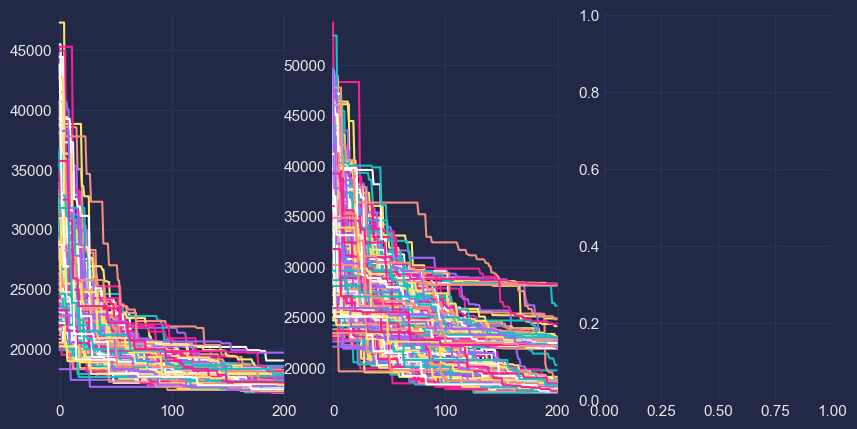

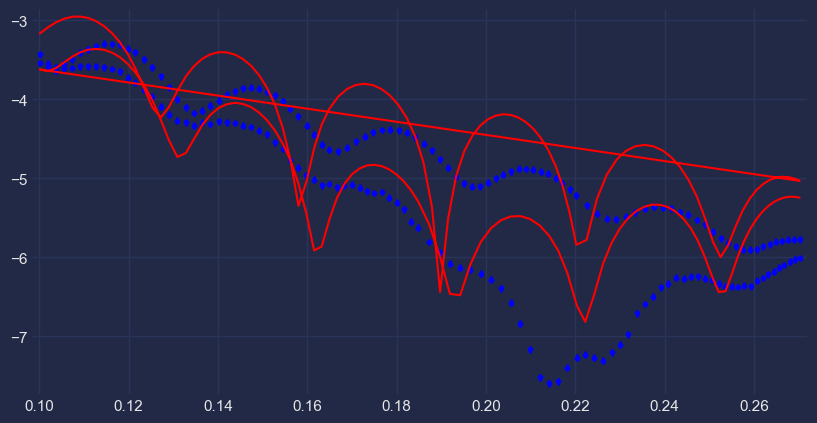

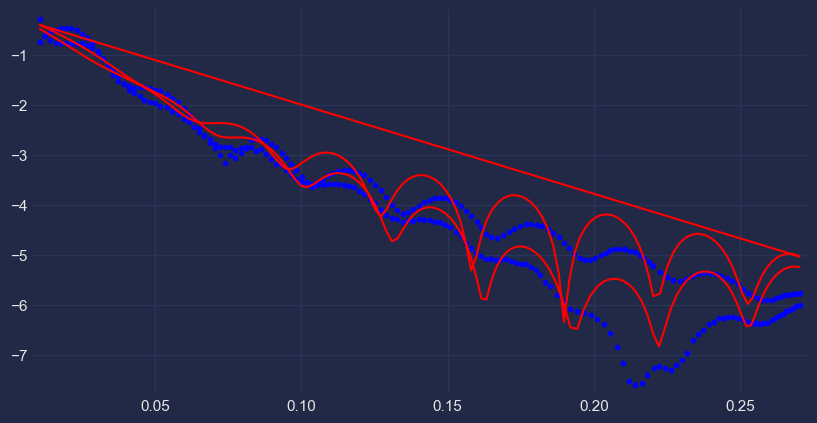

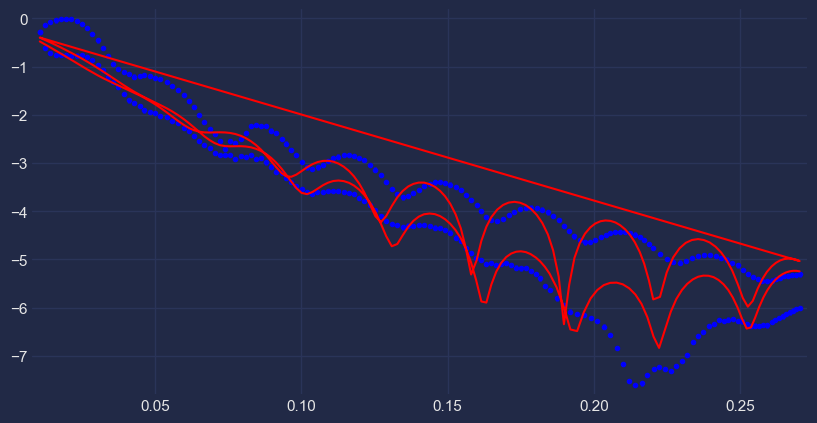

In [61]:
nwalkers = 200

fitter_1_lowq = CurveFitter(obj_283p7_lowq, nwalkers=nwalkers, moves = move)
fitter_1_extreme = CurveFitter(obj_283p7_extreme, nwalkers=nwalkers, moves = move)
fitter_1_lowq_scale = CurveFitter(obj_283p7_lowq_scale, nwalkers=nwalkers, moves = move)

fitter_1_lowq.initialise("prior")
fitter_1_extreme.initialise("prior")
fitter_1_lowq_scale.initialise("prior")

chain_1_lowq = fitter_1_lowq.sample(int(nwalkers), random_state=random_state)
chain_1_extreme = fitter_1_extreme.sample(int(nwalkers), random_state=random_state)
chain_1_lowq_scale = fitter_1_lowq_scale.sample(int(nwalkers), random_state=random_state)

lp_1_lowq = fitter_1_lowq.logpost
lp_1_extreme = fitter_1_extreme.logpost
lp_1_lowq_scale = fitter_1_lowq_scale.logpost

fig, ax = plt.subplots(ncols = 3)
ax[0].plot(-lp_1_lowq)
ax[1].plot(-lp_1_extreme)
ax[1].plot(-lp_1_lowq_scale)

obj_283p7_lowq.plot()
obj_283p7_extreme.plot()
obj_283p7_lowq_scale.plot()